# A few things to import

In [1]:
# frequently used builtins
import os
from collections import Counter, defaultdict

# frequently used data pkgs
import numpy as np
import pandas as pd
			
# careful import of matplotlib
try:
	import matplotlib.pyplot as plt
except ModuleNotFoundError as e:  # to catch ModuleNotFoundError: No module named '_tkinter'
	import matplotlib
	matplotlib.use('agg')
	import matplotlib.pyplot as plt

# some magic stuff
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format='retina'

# A snapshot: https://github.com/thorwhalen/likert/blob/7963bfcda643b222a30ef365829c6c5a72a8d0b3/likert/examples/in_their_own_words/__init__.py#L1-L334
# Current (if it still exists): https://github.com/thorwhalen/likert/blob/master/likert/examples/in_their_own_words/__init__.py

In [2]:
# Current (if it still exists): https://github.com/thorwhalen/likert/blob/master/likert/examples/in_their_own_words/__init__.py
# A past snapshot: https://github.com/thorwhalen/likert/blob/7963bfcda643b222a30ef365829c6c5a72a8d0b3/likert/examples/in_their_own_words/__init__.py#L1-L334

from likert.examples.in_their_own_words import *

# Get the raw source data

Here, we'll get the original survey data, in its raw form.

In [3]:
import numpy as np
from likert.examples.in_their_own_words import *

a = Analysis()
a.data.shape

(206, 36)

In [4]:
a.data.columns

Index(['SID', 'Q1', 'Q14', 'Q2_1', 'Q2_2', 'Q2_3', 'Q2_4', 'Q2_5', 'Q3_1',
       'Q3_2', 'Q3_3', 'Q3_4', 'Q3_5', 'Q3_6', 'Q3_7', 'Q3_8', 'Q3_9', 'Q3_10',
       'Q3_11', 'Q3_12', 'Q3_13', 'Q3_13_TEXT', 'Q4', 'Q5', 'Q5_3_TEXT', 'Q6',
       'Q6_6_TEXT', 'Q7', 'Q8', 'Education Number', 'Q9', 'Q10', 'Q11', 'Q12',
       'Q15', 'Education Number.1'],
      dtype='object')

In [5]:
a.questions

SID                                                                  ID
Q1                    1. What term or label do\nyou use to identify ...
Q14                                                  Self-term category
Q2_1                  2. Do you use the same label or another when\n...
Q2_2                  2. Do you use the same label or another when\n...
Q2_3                  2. Do you use the same label or another when\n...
Q2_4                  2. Do you use the same label or another when\n...
Q2_5                  2. Do you use the same label or another when\n...
Q3_1                  3. If\nyou could choose how other people refer...
Q3_2                  3. If\nyou could choose how other people refer...
Q3_3                  3. If\nyou could choose how other people refer...
Q3_4                  3. If\nyou could choose how other people refer...
Q3_5                  3. If\nyou could choose how other people refer...
Q3_6                  3. If\nyou could choose how other people r

## Preparing the data for self-term word clouds

Looking at the free form terms respondents use to describe themselves (we call these "self-terms"). 

In [6]:
print(f"There are {len(a.all_names)} respondents, each giving their self-identification term\n")

There are 206 respondents, each giving their self-identification term



In [7]:
print(f"Original data")
print(f"Out of {len(a.all_names)} respondents...")
n_unik_original_names = len(np.unique(a.all_names))
print(f"...there are {n_unik_original_names} unique self-identification expressions ('self-terms')")

Original data
Out of 206 respondents...
...there are 97 unique self-identification expressions ('self-terms')


Let's make a word cloud from these.

In our word cloud, the size of each term will represent the frequency of its usage by the respondents; the larger the term, the more frequently it was used. We will use the default color scheme, which randomly assign colors to these terms from the default coloring palette provided by the word cloud application. 

It's important to note that the color allocation carries no semantic meaning and is solely intended for readability and aesthetic enhancement.

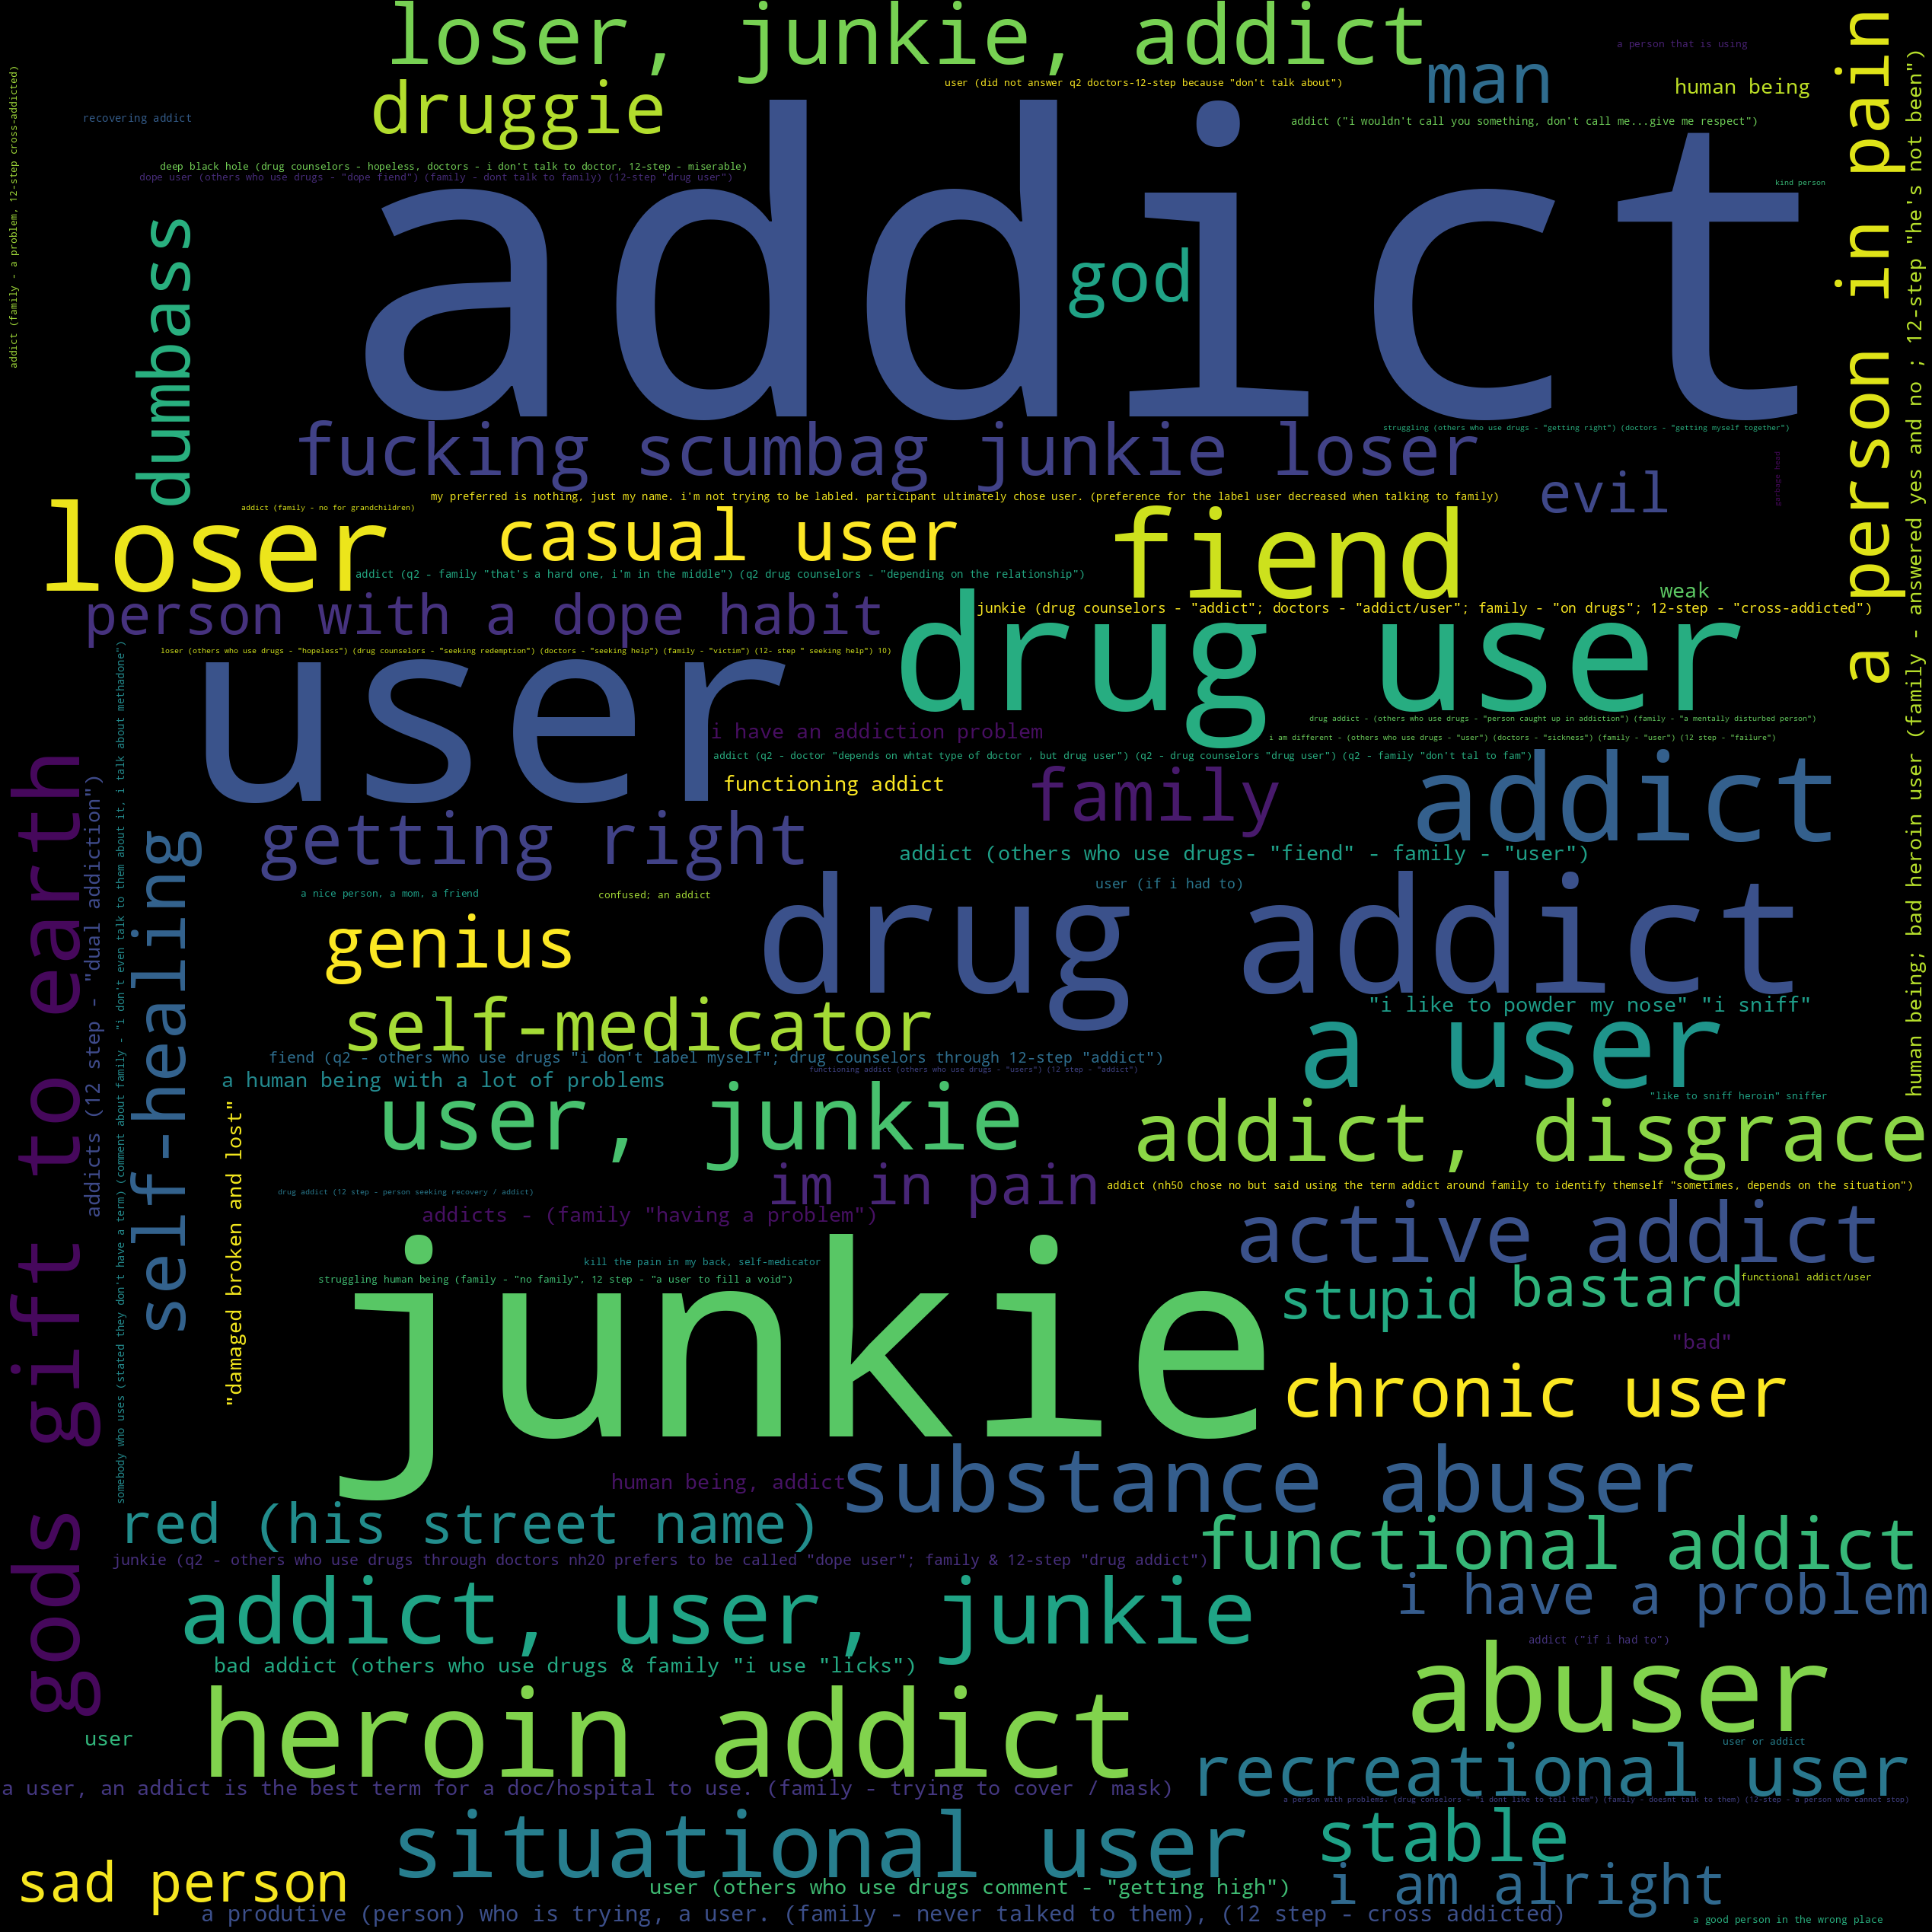

In [8]:
wc = word_cloud(a.all_names)
# wc.to_file(f'img/in_their_words_cloud_with_no_prep_{n_unik_original_names}_unique_terms.pdf')
wc.to_image()

In this particular word cloud, we're working with multi-word expressions. As such, it's important to scrutinize the surrounding words to comprehend the full expression. This is because the full expression will consist of multiple words of the same color, aligned either vertically or horizontally. For instance, upon first glance, one might observe the term addict repeated several times. However, a closer look reveals that it's part of several distinct expressions like `addict, disgrace`, `drug addict`, or `loser, junkie, addict`.

One particular one seems to be a true duplicate, but when looking into the data, one realizes that sometimes there's trailing spaces, which we obviously can't see on the word cloud. 

One particular instance of `addict` seems like a perfect duplicate, but a detailed analysis of the underlying data reveals occasional trailing spaces, which are not visible in the word cloud.

In [22]:
set([x for x in a.all_names if x.strip() == 'addict'])

{'addict', 'addict '}

Additionally, some terms appear elongated and smaller in the word cloud.
As it often is with free form, we the data is all over the spectrum, 
and here you can see the range of lengths of responses
(because the respondents added comments to their answers, which were 
recorded as their response).

See below the smallest and longest "terms".

In [23]:
print_shortest_and_longest(a.all_names)

Smallest:
	god
	man
	user
	weak
	evil

Largest:
	my preferred is nothing, just my name. i'm not trying to be labled. participant ultimately chose user. (preference for the label user decreased when talking to family)
	loser (others who use drugs - "hopeless") (drug counselors - "seeking redemption") (doctors - "seeking help") (family - "victim") (12- step " seeking help") 10) 
	addict (q2 - doctor "depends on whtat type of doctor , but drug user") (q2 - drug counselors "drug user") (q2 - family "don't tal to fam")
	a person with problems. (drug conselors - "i dont like to tell them") (family - doesnt talk to them) (12-step - a person who cannot stop)
	somebody who uses (stated they don't have a term) (comment about family - "i don't even talk to them about it, i talk about methadone")


These are all examples of artifacts in the data that require appropriate processing.

Let's proceed to the cleaning phase. In this step, we will:

* Eliminate any text following a parenthesis.
* Replace any occurrence of " -" with an empty string.
* Remove any trailing spaces.

After doing this, we are left with 76 unique terms. 
None of the terms were deleted. 
They were just edited so they can more accurately contribute to the term count.

In [24]:
print(f"Before: {len(a.orig_unik)} unique names. After: {len(a.unik_names)} unique names")

Before: 97 unique names. After: 76 unique names


Let's have a look at what our word cloud looks like now that we've reduced the number of unique terms a bit.

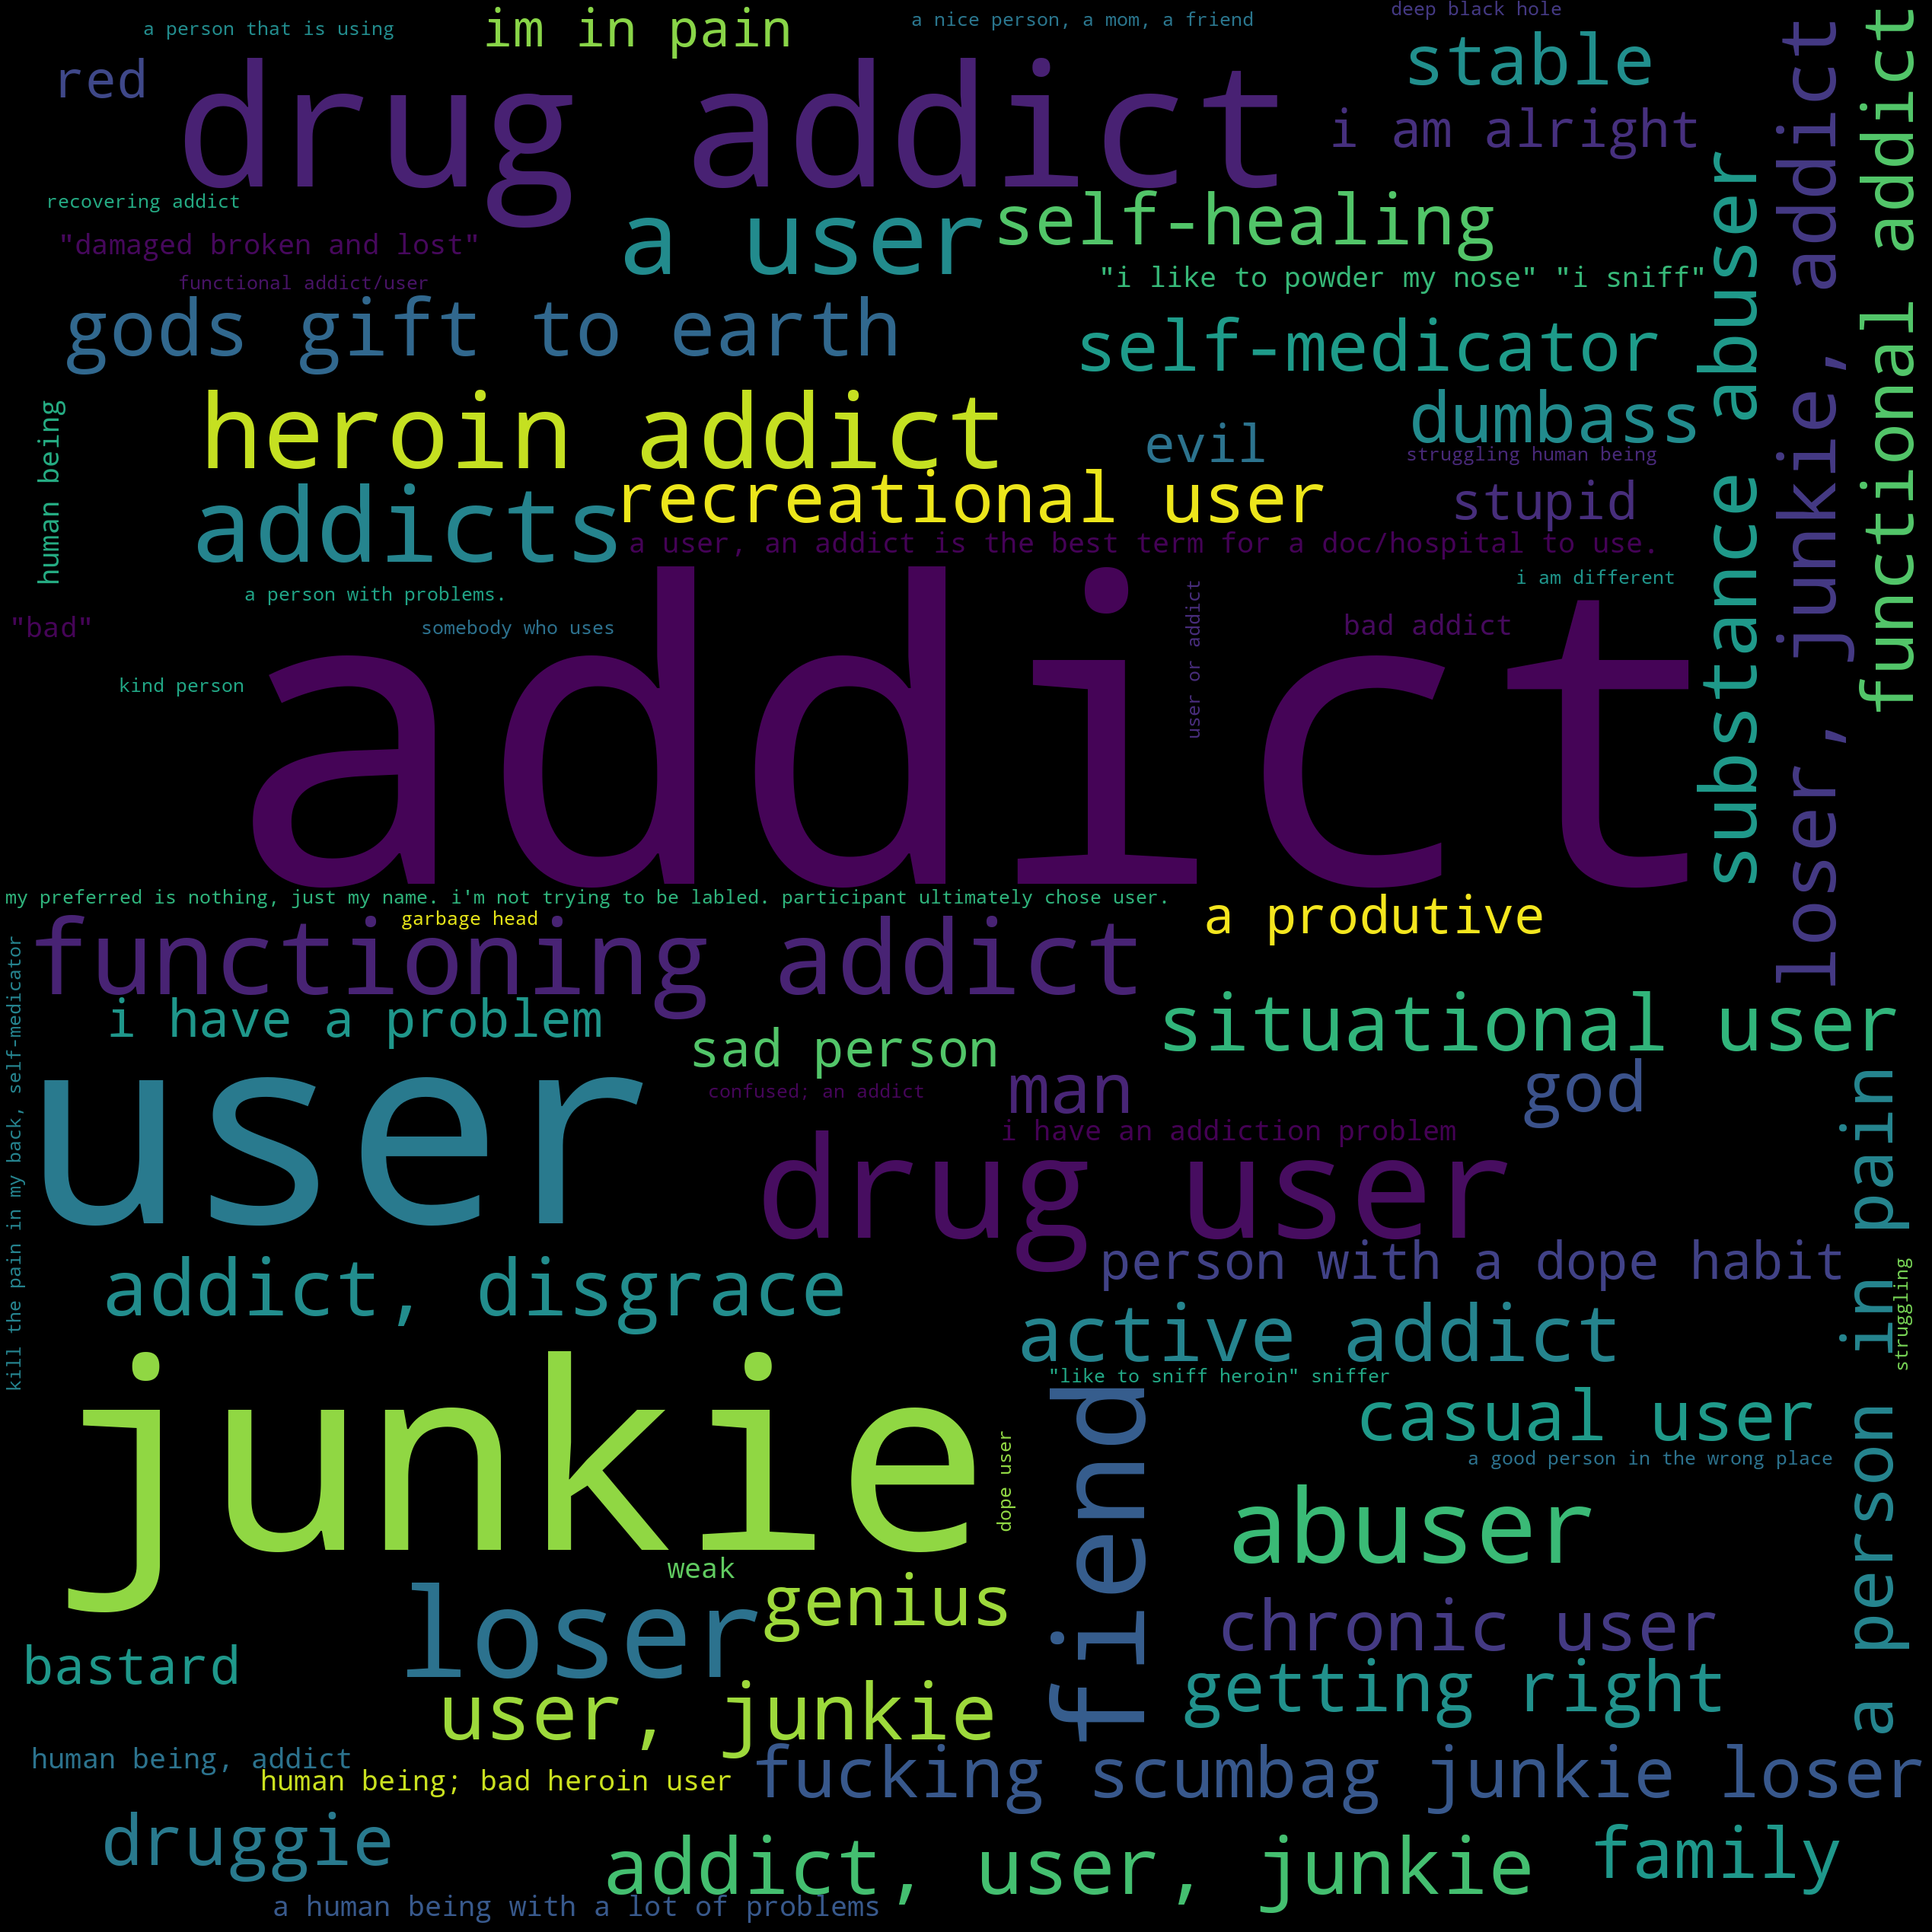

In [27]:
wc = word_cloud(a.names)
wc.to_file(f'img/in_their_words_cloud_with_minimal_prep_with_{len(np.unique(a.names))}_terms.pdf')
wc.to_image()

That's a bit cleaner!

But with cleaner data, comes more clarity on what further cleaning needs to be done.

We see that there's still a few long terms in there, and terms with quotes, and other punctuation that we may or may not want to have. 

Let's have a peep at the 40 longest terms we're left with.

In [28]:
print("\t" + "\n\t".join(sorted(a.unik_names, key=len, reverse=True)[:40]))

	my preferred is nothing, just my name. i'm not trying to be labled. participant ultimately chose user.
	a user, an addict is the best term for a doc/hospital to use.
	kill the pain in my back, self-medicator
	a human being with a lot of problems
	"i like to powder my nose" "i sniff"
	a good person in the wrong place
	"like to sniff heroin" sniffer
	a nice person, a mom, a friend
	human being; bad heroin user
	fucking scumbag junkie loser
	i have an addiction problem
	"damaged broken and lost"
	person with a dope habit
	a person with problems.
	a person that is using
	struggling human being
	functional addict/user
	loser, junkie, addict
	addict, user, junkie
	confused; an addict
	human being, addict
	functioning addict
	gods gift to earth
	functional addict
	recovering addict
	recreational user
	somebody who uses
	substance abuser
	situational user
	a person in pain
	addict, disgrace
	i have a problem
	deep black hole
	self-medicator
	i am different
	user or addict
	heroin addict
	gett

So let's clean this data up a bit further.

Here, we'll:
* remove quotes
* remove indefinite articles (a, an)
* A few manual corrections (listed below)
* split terms (more on that now)

One clean-up problem needs to be mentioned here: What do we do with comma or semi-colon separated lists. 

If the respondant self-identifies as `loser, junkie, addict`, what do we do with that? We could, for example:
* just chose one, but we'd be introducing our own bias in the data
* just drop the respondent from our data, but we'd be losing a lot of data, and still introducing some selection-bias
* split the terms into their components, and share the "count weight" between them

We chose to go with the last solution. 
In this solution, a term such as `loser, junkie, addict` will not contribute `1` to the count, but instead, `loser`, `junkie`, and `addict` will each contribut `1/3` (a third) to the count. 

The manual corrections were:
```
* addicr -> addict
* functioning addict -> functional addict
* a user, an addict is the best term for a doc/hospital to use. -> user, addict
* humbeing with lot of problems -> a human being with lot of problems
* my preferred is nothing, just my name. i'm not trying to be labled. participant ultimately chose user. -> user
```

In [29]:
for xx, xxx in a.full_substitutions.items():
    print(f"{xx} -> {xxx}")

addicr -> addict
functioning addict -> functional addict
a user, an addict is the best term for a doc/hospital to use. -> user, addict
humbeing with lot of problems -> a human being with lot of problems
my preferred is nothing, just my name. i'm not trying to be labled. participant ultimately chose user. -> user
produtive -> productive
i like to powder my nose i sniff -> heroin sniffer
person with problems. -> person with problems
addicts -> addict
like to sniff heroin sniffer -> heroin sniffer


In [34]:
# # Note: One response says "fiend": Was it "friend" that was meant?

# remove_strings = re.compile('|'.join([
#     '"', 
# ]))

# replace_with_space = re.compile('|'.join([
#     '\ a\ ', '\ an\ ', '^a\ ', '^an\ '
# ]))

# def str_preprocessing(string):
#     if string in full_substitutions:
#         print(f"---> {string}")
#         string = full_substitutions[string]
#     string = remove_strings.sub('', string)
#     string = replace_with_space.sub(' ', string)
#     return string.strip()

# splitters = re.compile(',|/|\Wor\W|;')
# # splitters = re.compile('alkjdfoi')

# def string_to_weighed_names(string):
#     split_strings = splitters.split(string)
#     n = len(split_strings)
#     for s in split_strings:
#         yield s, 1 / n
    
# def name_weights(
#     strings, 
#     str_preprocessing=str_preprocessing,
#     string_to_weighed_names=string_to_weighed_names,
# #     str_preprocessing=lambda string: string,
# #     string_to_weighed_names=lambda string: [(string, 1)],
# ):
#     for string in map(str_preprocessing, strings):
#         for name, weight in string_to_weighed_names(string):
#             name = name.strip()
#             if name == '':
#                 raise ValueError(f"Oops with {string}")
#             yield name, weight
        
# def get_word_counts(names):
#     counts = Counter()
#     for name, weight in name_weights(names):
#         counts.update({name: weight})

#     counts = counts.most_common()
#     return counts

# counts = get_word_counts()
# print(f"Number of unique terms: {len(counts)=}")

In [35]:
print(f"Number of unique terms: {len(a.orig_counts)=}")

Number of unique terms: len(a.orig_counts)=67


We now have 68 unique terms, weighted according to usage frequency. 

Let's word-cloud those!

In [38]:
sum(v for k, v in a.orig_counts)

206.00000000000003

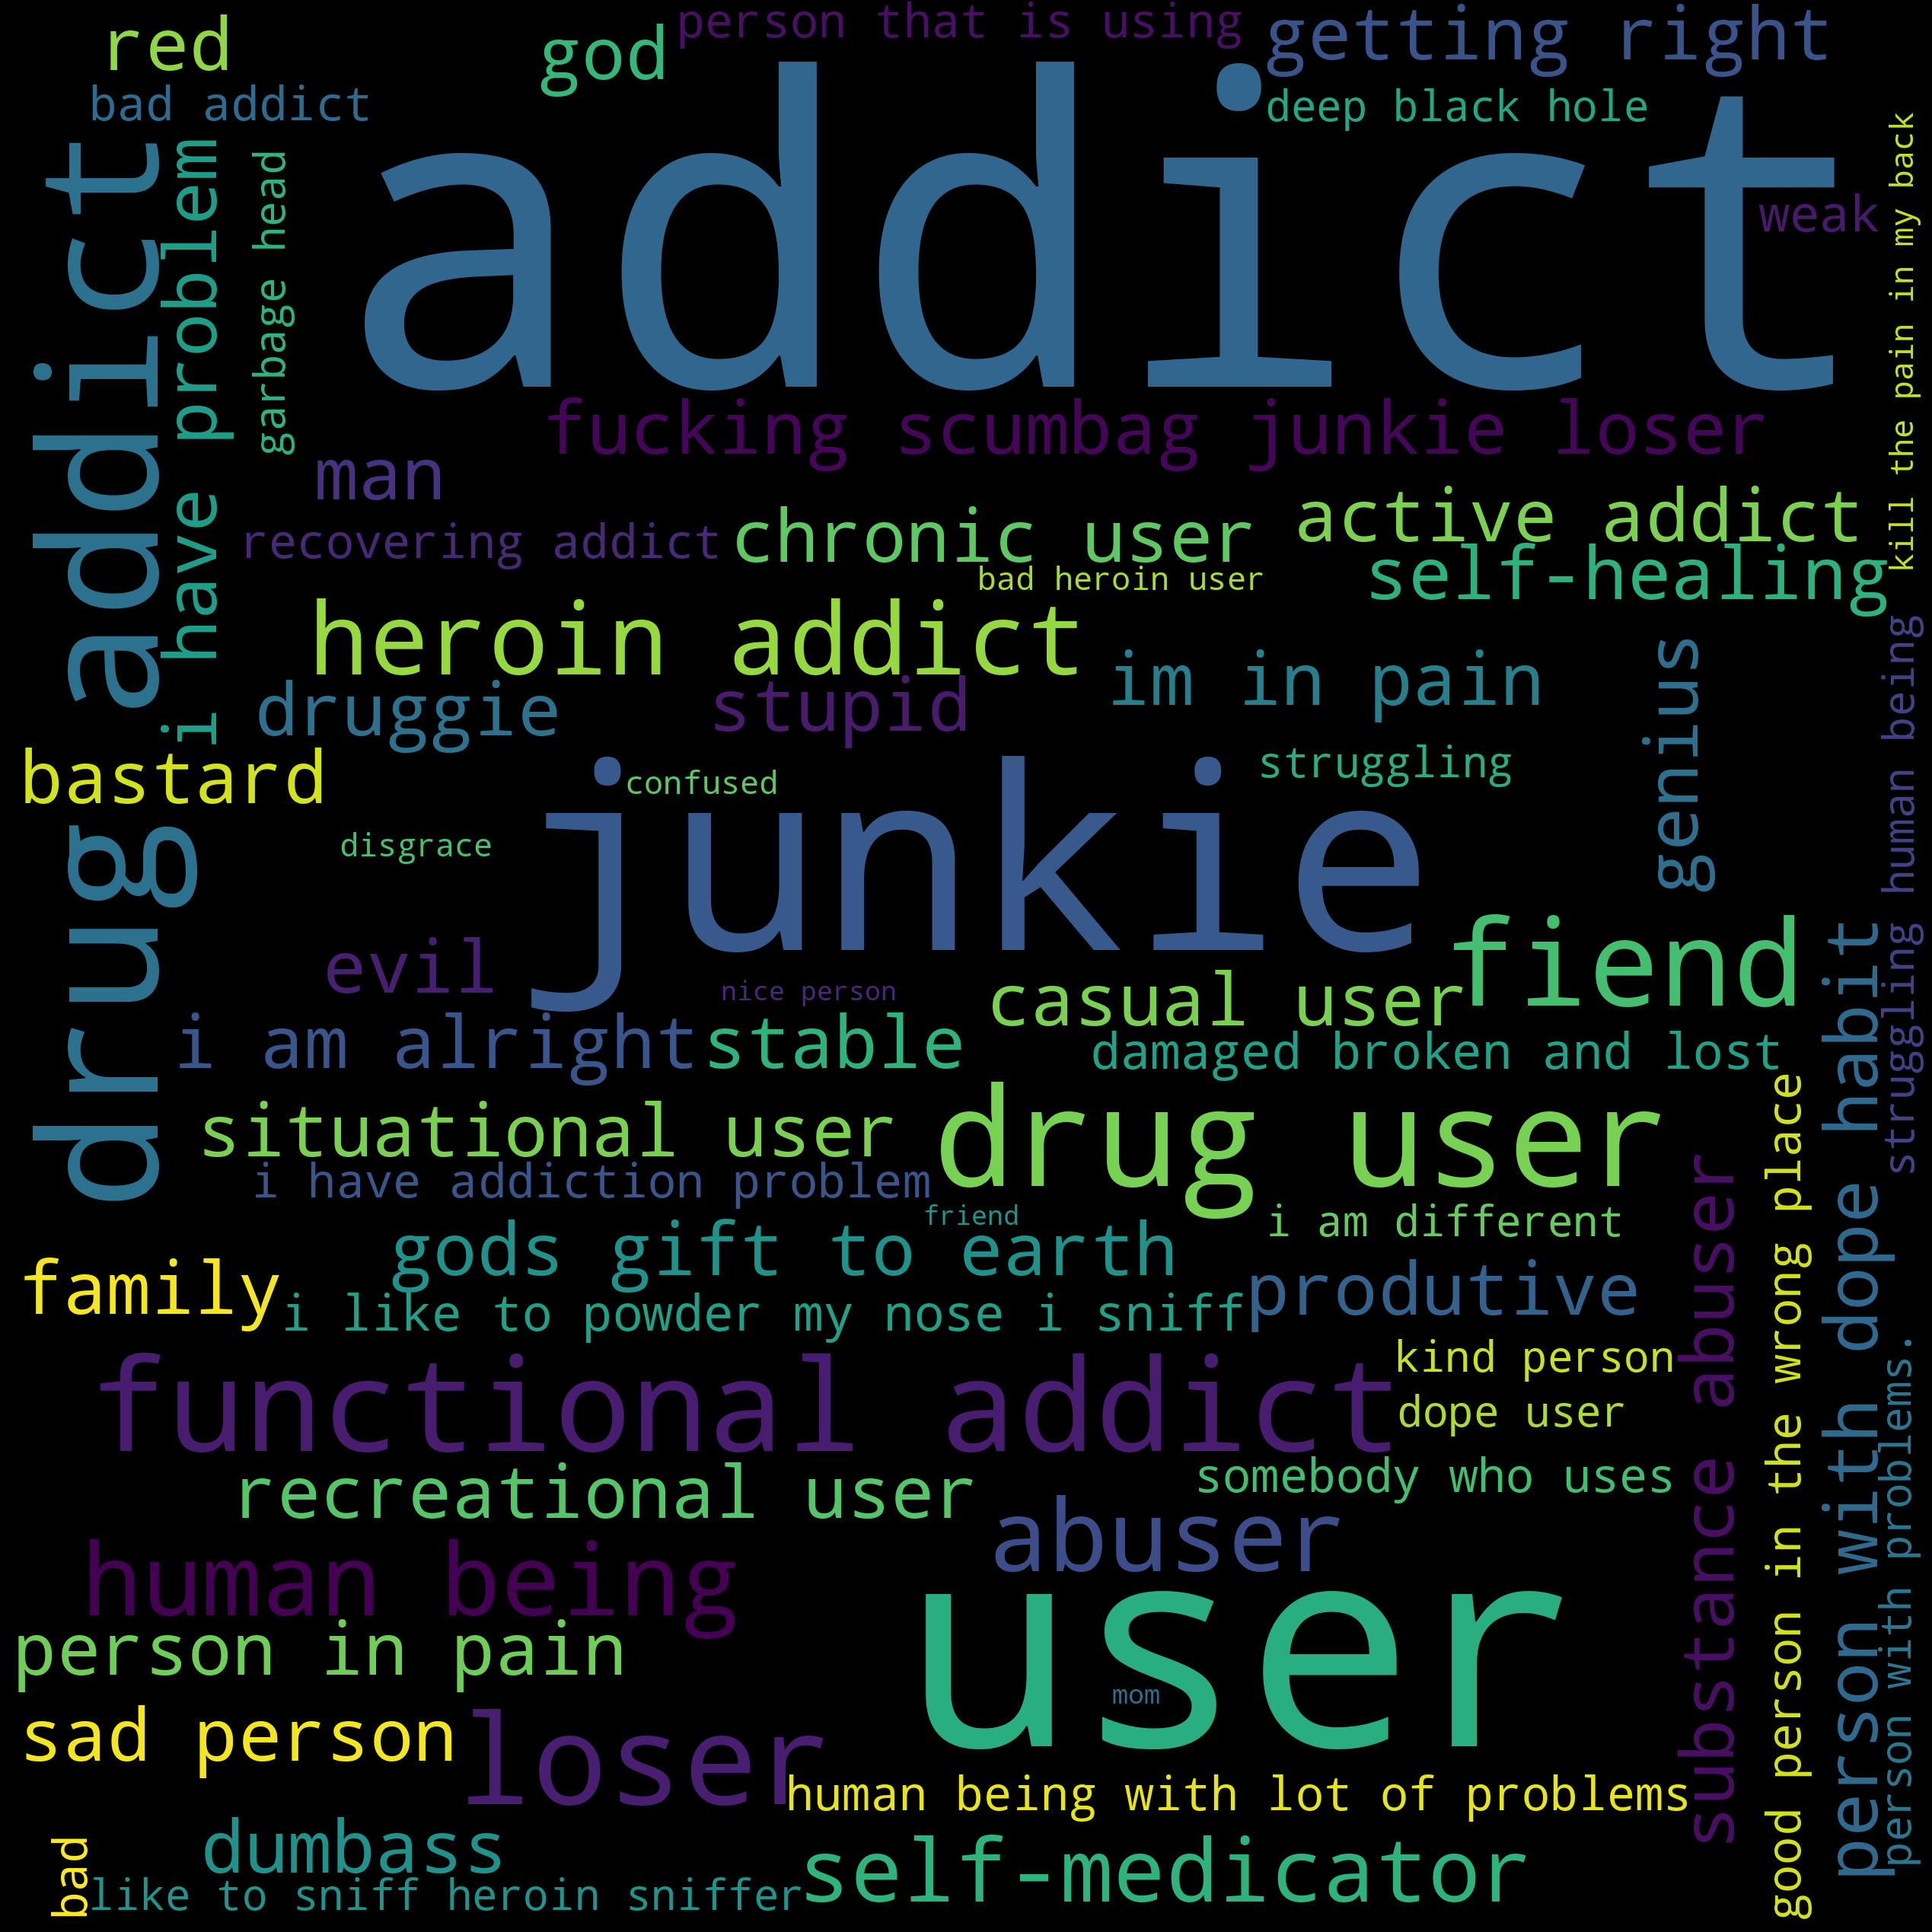

In [39]:
wc = word_cloud(dict(a.orig_counts))
wc.to_file(f'img/in_their_words_cloud_{len(a.orig_counts)}_terms.pdf')
wc.to_image()

In [143]:
# not_too_long_names = list(filter(lambda x: len(x) < 20, names))
# len(not_too_long_names)

## Playing around with the format a bit

A word cloud with only white ink on black background.

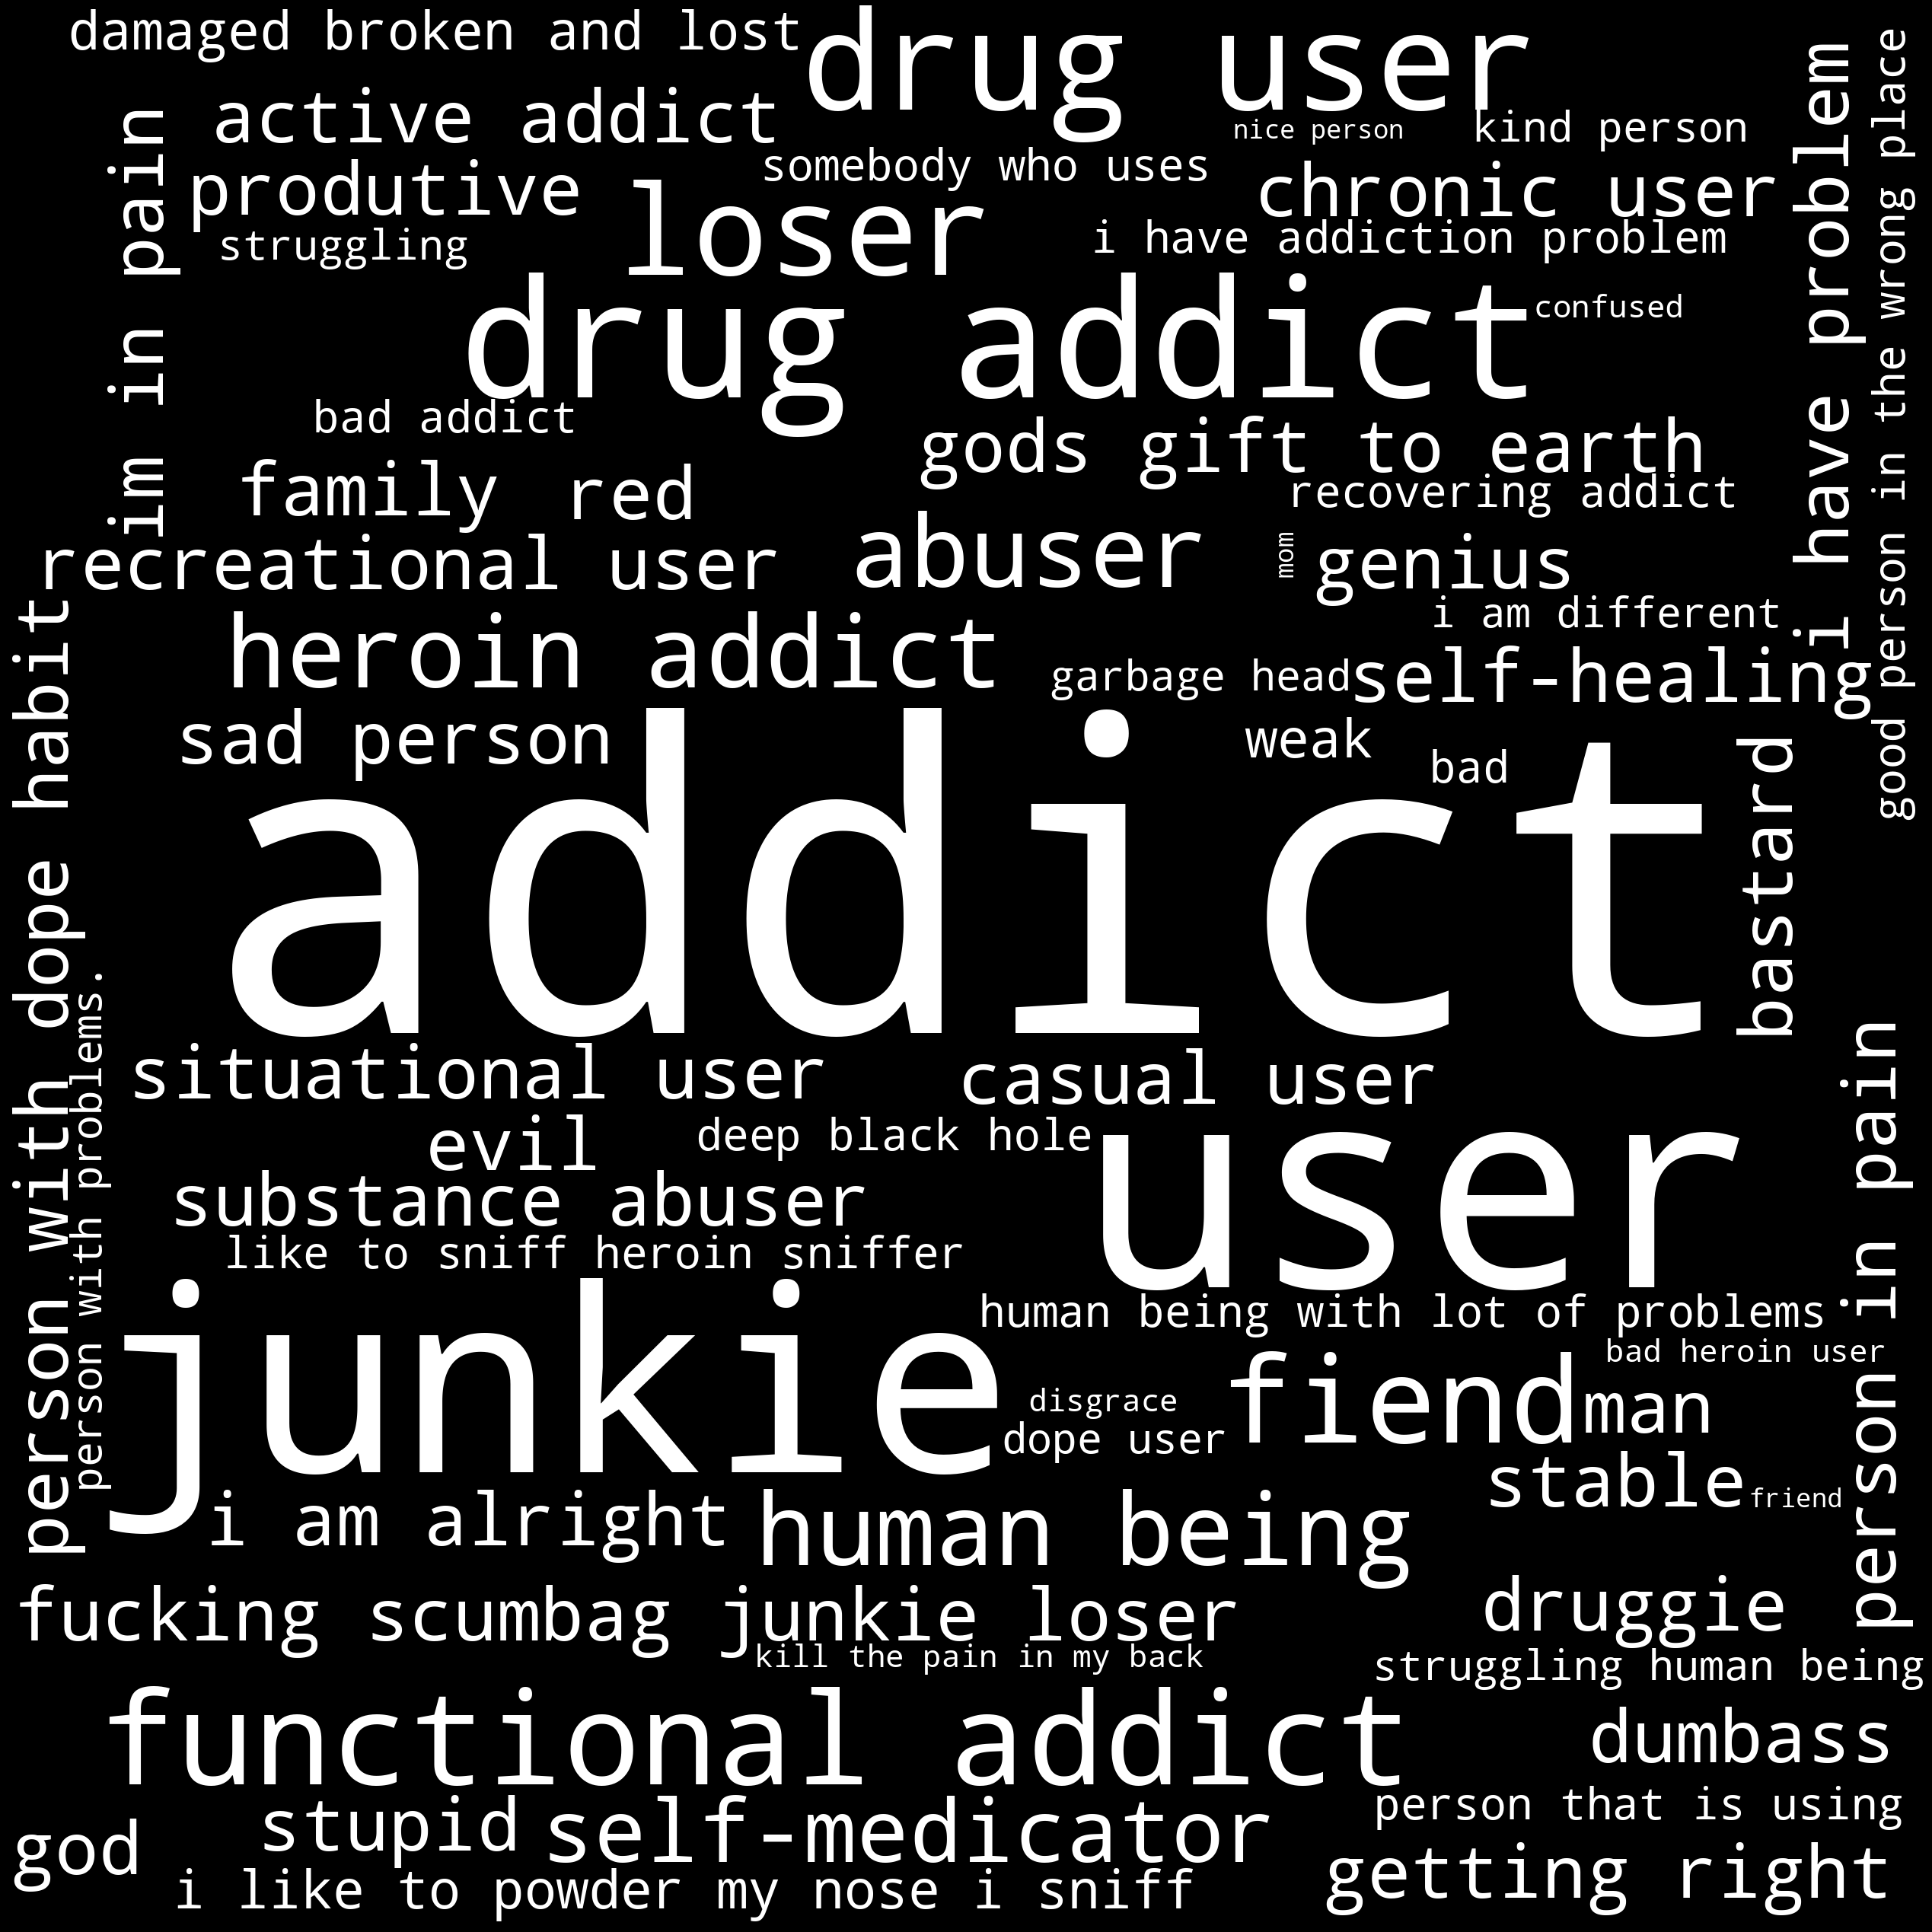

In [40]:
wc = word_cloud(dict(a.orig_counts))
wc = wc.recolor(color_func=lambda *a, **k: '#ffffff')
wc.to_file('img/in_their_words_cloud_white_on_black_67.pdf')
wc.to_image()

Only black ink with white background (perhaps better for printing?).

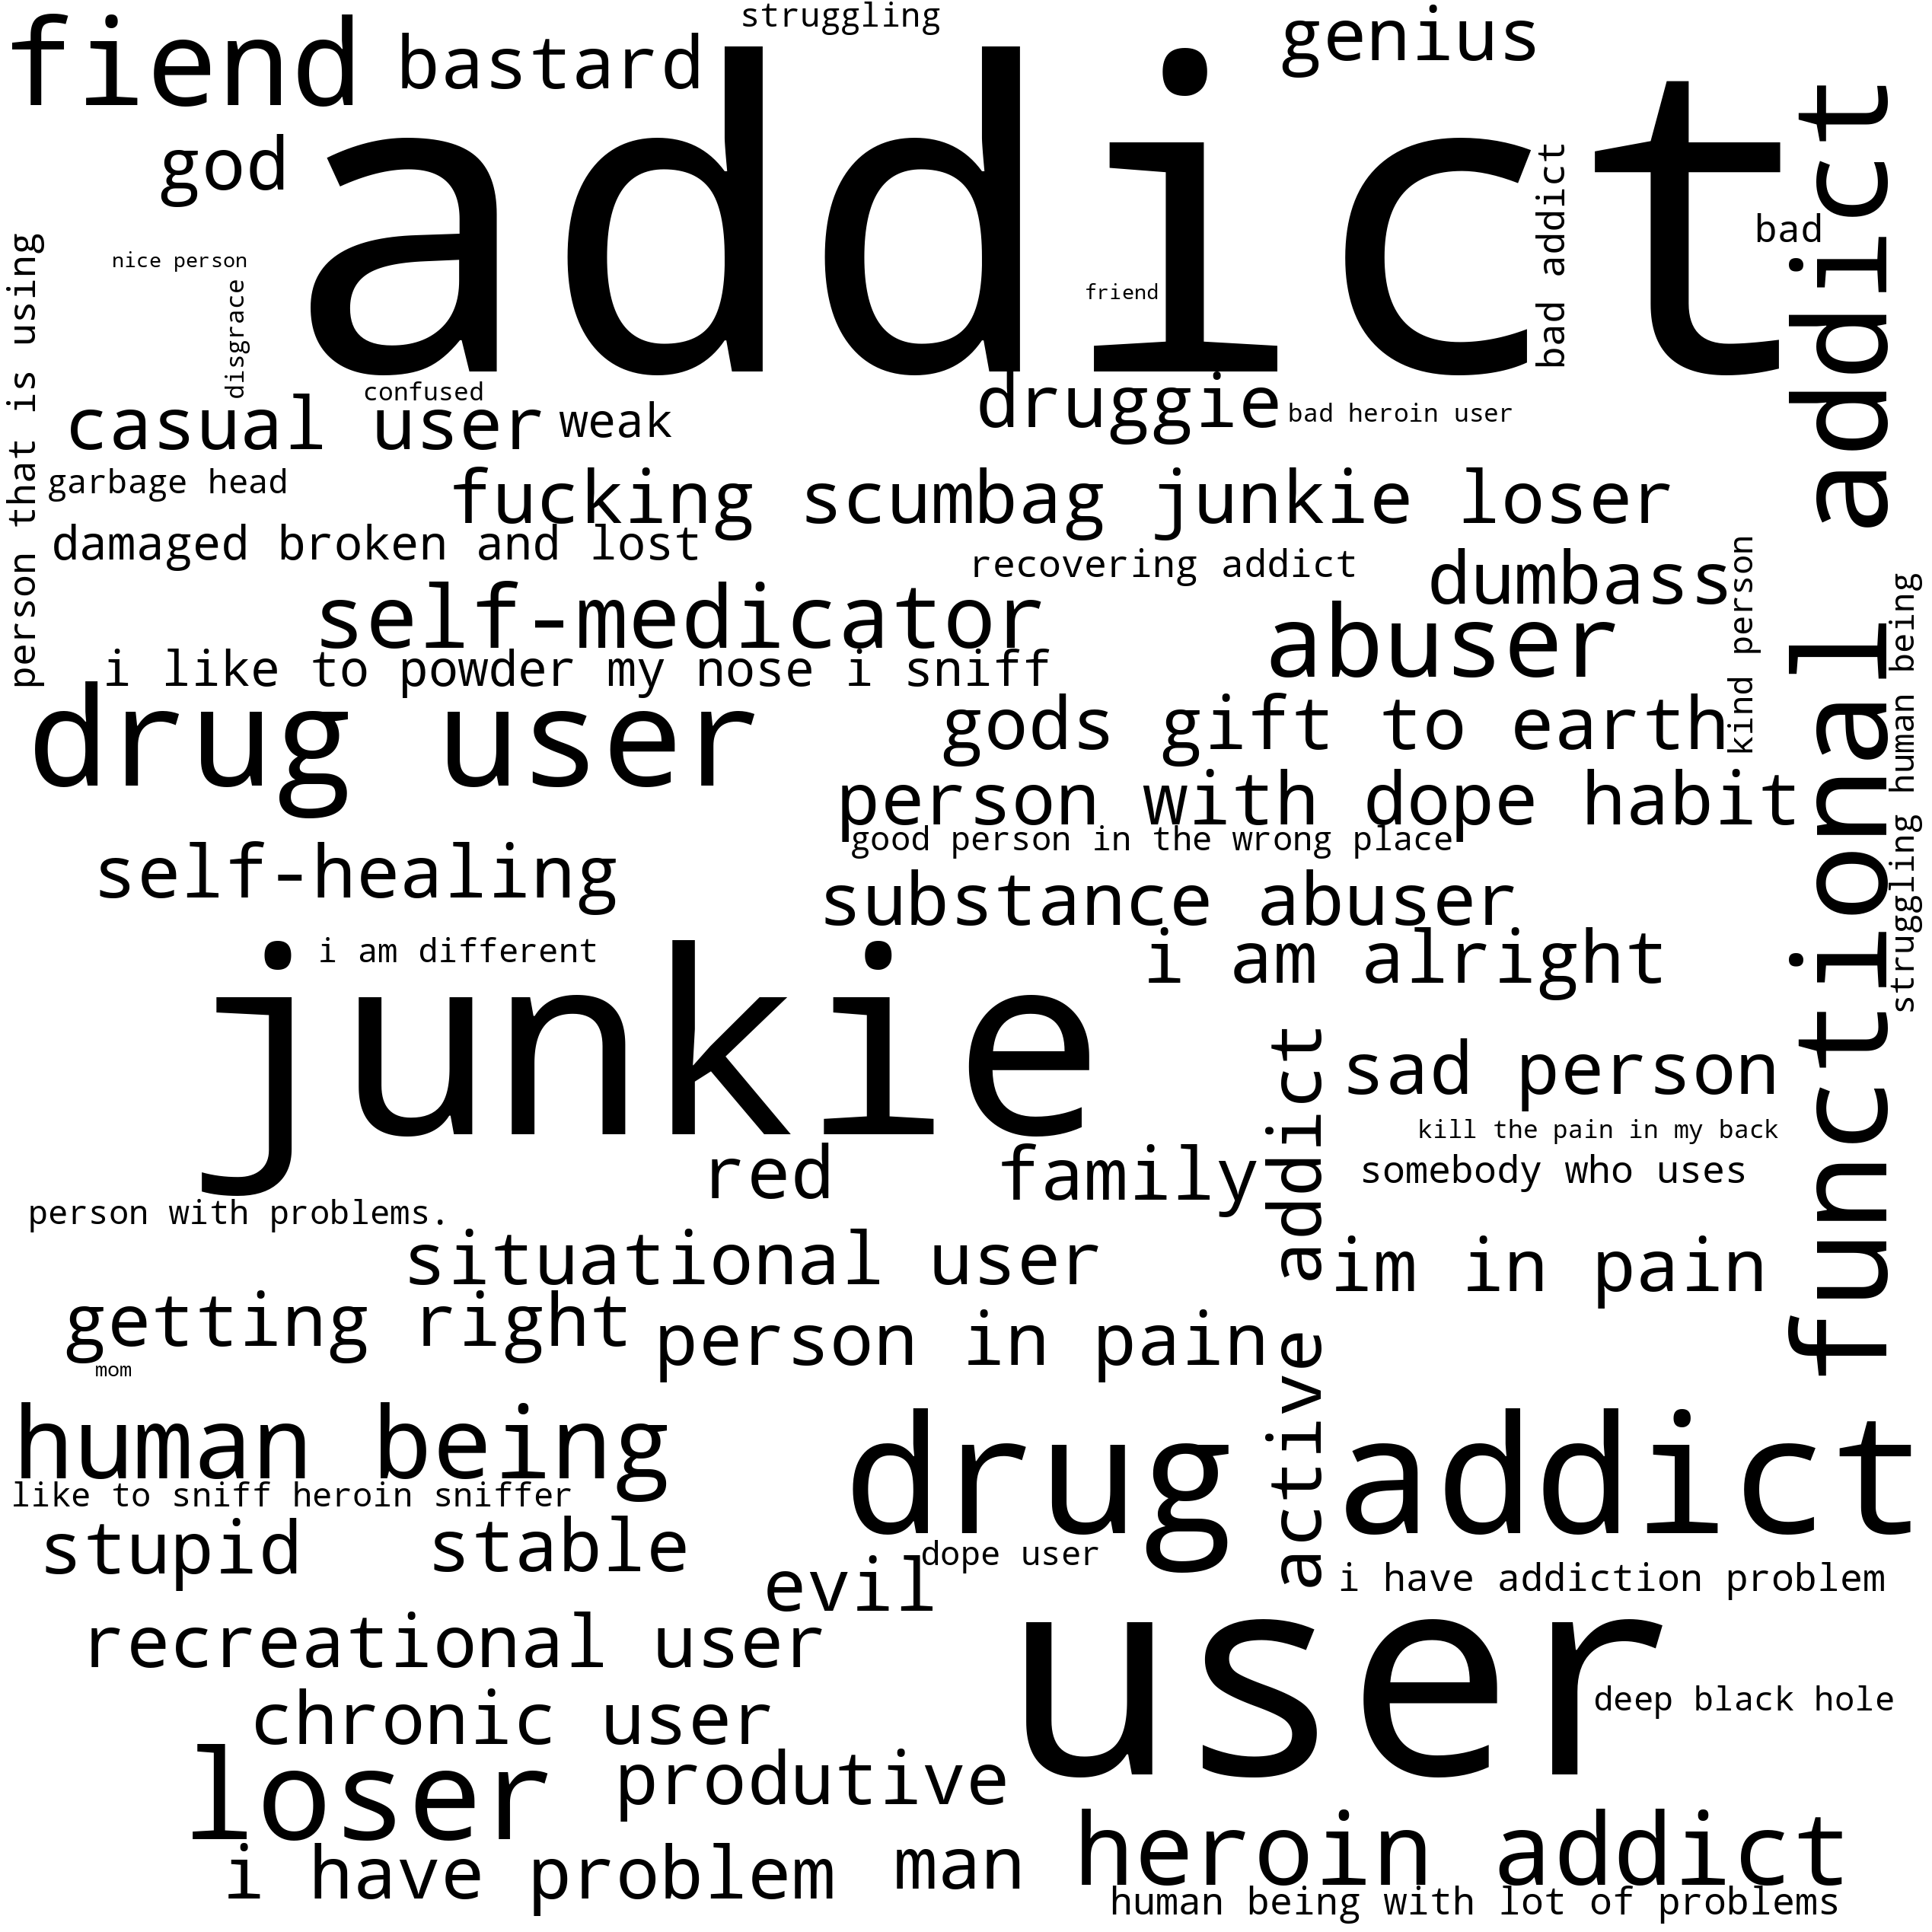

In [41]:
wc = word_cloud(dict(a.orig_counts), background_color='white')
wc = wc.recolor(color_func=lambda *a, **k: '#000000')
wc.to_file('img/in_their_words_cloud_black_on_white_67.pdf')
wc.to_image()

Wait a minute! It looks like "addict" appears several times! But that's because the actual word that is being used is an expression. 
Things like "functional addict" or "active addict" etc. Maybe this is confusing and we need to make it more obvious that a word is part of an expression?
Consider for example using dashes to connect words of an expression together. 

In my opinion is doesn't look as good. But it does help the user to identify the full expression more easily. 

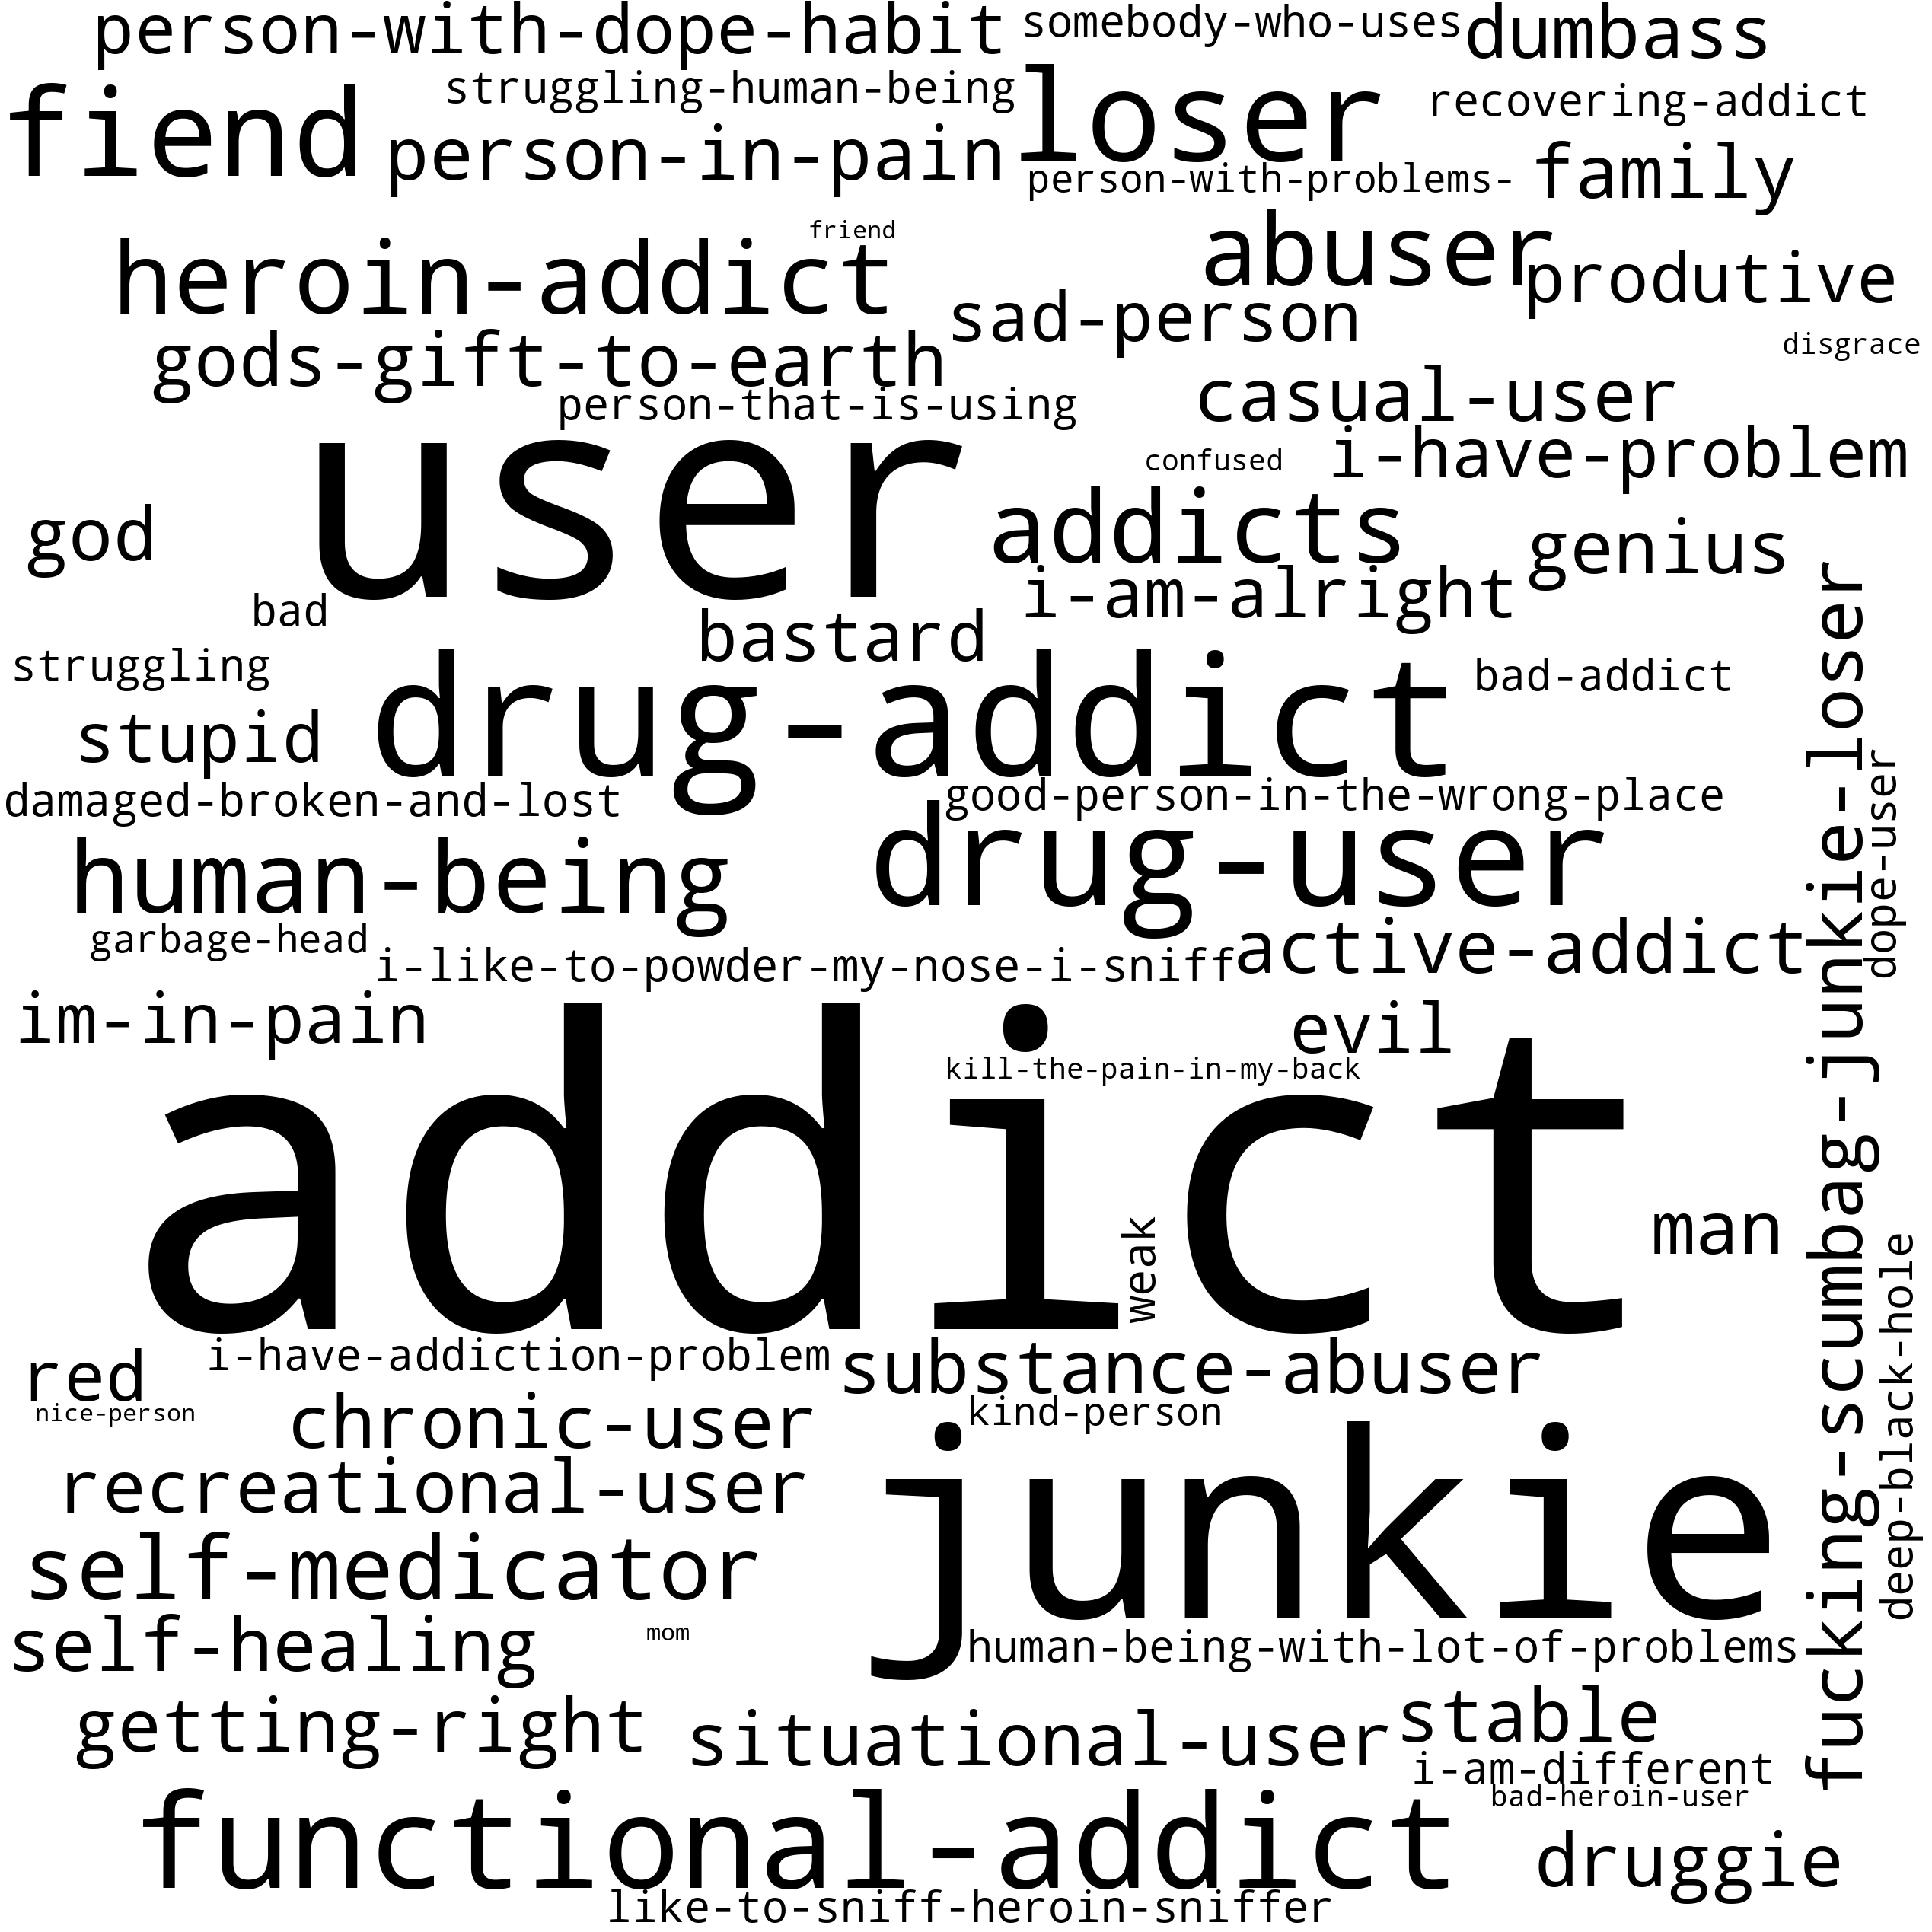

In [19]:
import re
word_counts_with_underscores = {re.sub('\W', '-', w): v for w, v in a.orig_counts}
wc = word_cloud(word_counts_with_underscores, background_color='white')
wc = wc.recolor(color_func=lambda *a, **k: '#000000')
wc.to_file('img/in_their_words_cloud_all_black_w_white_background_and_dashes.pdf')
wc.to_image()

## Using color to convey categories

In [10]:
from likert.examples.in_their_own_words import *

print(f"{len(a.counts)=}")


---> a user, an addict is the best term for a doc/hospital to use.
---> addicts
---> addicts
---> functioning addict
---> my preferred is nothing, just my name. i'm not trying to be labled. participant ultimately chose user.
---> functioning addict
len(a.counts)=61


In [20]:
del a.category_for_expression

In [23]:
a.category_for_expression['addict']

'addict'

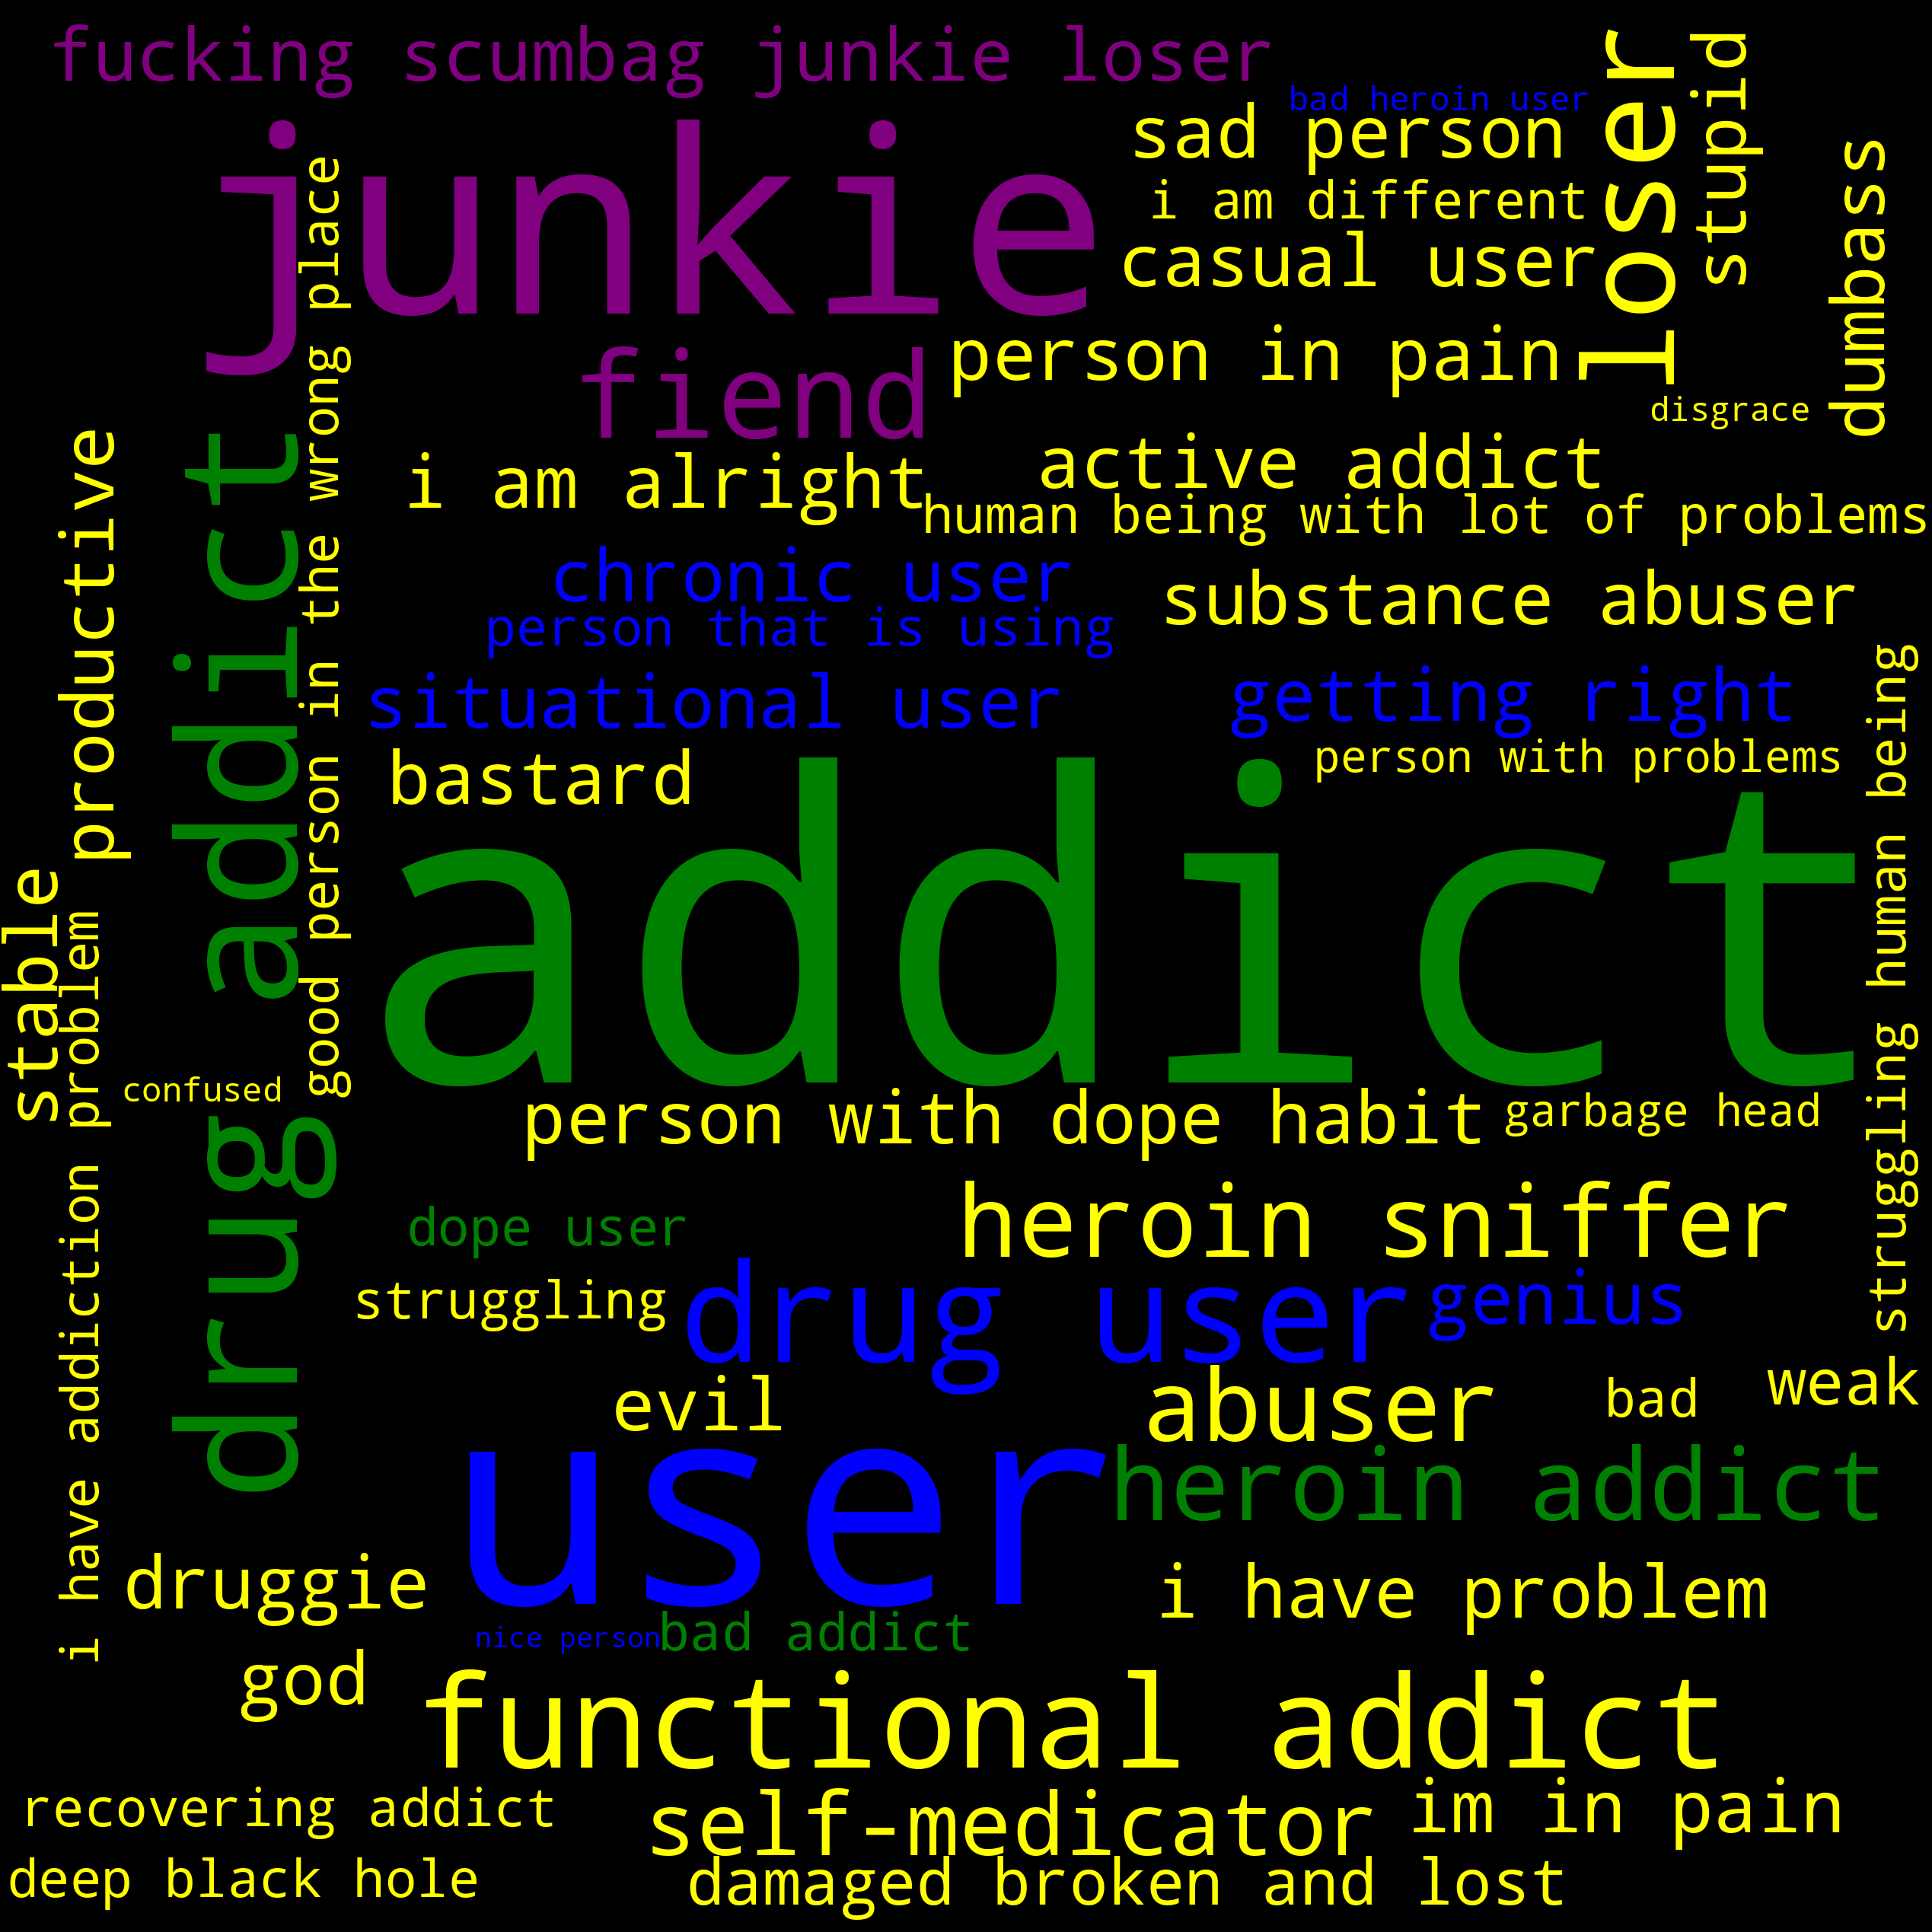

In [25]:
random_state = 0  # TODO: doesn't actually fix the rendering! But should.

wc = word_count_for_counts_with_color_control(
    a.counts_dict_for_categorized_names, 
    a.category_for_expression.get, 
    score_to_color=a.color_for_category.get,
    random_state=random_state
)
wc.to_file(f'img/colored_by_category_{random_state}.pdf')
wc.to_image()


## Using color to convey "sentiment" (co-notation)

In [28]:
from likert.examples.in_their_own_words import gradients_of_hex_colors, mk_score_to_color, word_count_for_counts_with_color_control

base_color = 'grey'
score_to_color = mk_score_to_color(base_color, min_score=-1, max_score=1)

In [29]:
gradients_of_hex_colors('grey')[:4]

['#818181', '#818181', '#828282', '#838383']

#### auto-sentiment

Now, we'd like to use the "color", or rather "shade", of the words to illustrate another dimension of the data. We chose to represent "sentiment" here -- that is, whether the word used has a positive or negative conotation, and even how positive or negative the conotation is. 

First, we'll use `flair`, a python package that offers automatic sentiment scores based on their model. 

In [24]:
# from likert.examples.in_their_own_words import sentiment_score

# word_to_score = sentiment_score

# wc = word_count_for_counts_with_color_control(counts, word_to_score, score_to_color, random_state=0)
# # wc.to_file(f'img/in_their_words_cloud_w_sentiment_{base_color}.pdf')
# wc.to_image()

#### edit sentiments

Perhaps we'd like to start with the auto-sentiments offered by the `flair` model, but manually edit them to fit our own context and beliefs about the conotation of the words in that context. 

First we make an excel with the "auto-sentiments":

In [17]:
sentiments = (
    pd.DataFrame([{'auto expression': word, 'auto sentiment': sentiment_score(word)} for word, _ in counts])
    .sort_values(by='auto sentiment')
    .reset_index(drop=True)
)
sentiments.to_excel('auto_sentiment_scores.xlsx', index=False)
sentiments

auto expression  auto sentiment
0         garbage head       -0.999995
1           im in pain       -0.999960
2             disgrace       -0.999919
3                fiend       -0.999870
4              druggie       -0.999844
..                 ...             ...
63   recreational user        0.998275
64  gods gift to earth        0.998517
65         human being        0.999663
66        self-healing        0.999665
67   somebody who uses        0.999711

[68 rows x 2 columns]

Then we put this on a [google sheet](https://docs.google.com/spreadsheets/d/1oxO1iyGTbEOU6CnT009EnbnMbnAsBxEetCXg90W2SMg/edit?usp=sharing), 
add some "expression" and "sentiment" columns, originally pointing to the auto columns, but meant to be overwritten to make edits 
(to expression and/or sentiment score). 

We keep this original "base" sheet as a template which we can then copy to other sheets to make edits. 

**It's important that the edits do not change the "auto express" or "auto sentiment" AT ALL, since these are links back to our original data**

In the next few cells, we will show how one can then use this edited table to create a word cloud with edited expressions 
(here only one edit -- `produtive -> productive`) and sentiments (here only five sentiments, whose sign we changed. 

We download the edited google sheet as and excel called `"terms_sentiments_and_categories.xlsx"` and...


Two sociologists went through the data, editing the words and scoring each group with a sentiment score (doing this twice, one week apart, and taking the average of all four scores as the final score). This data can be found in the `terms_sentiments_and_categories.xlsx` file. 

len(a.counts)=61, len(_word_to_score_dict)=60, len(t)=60


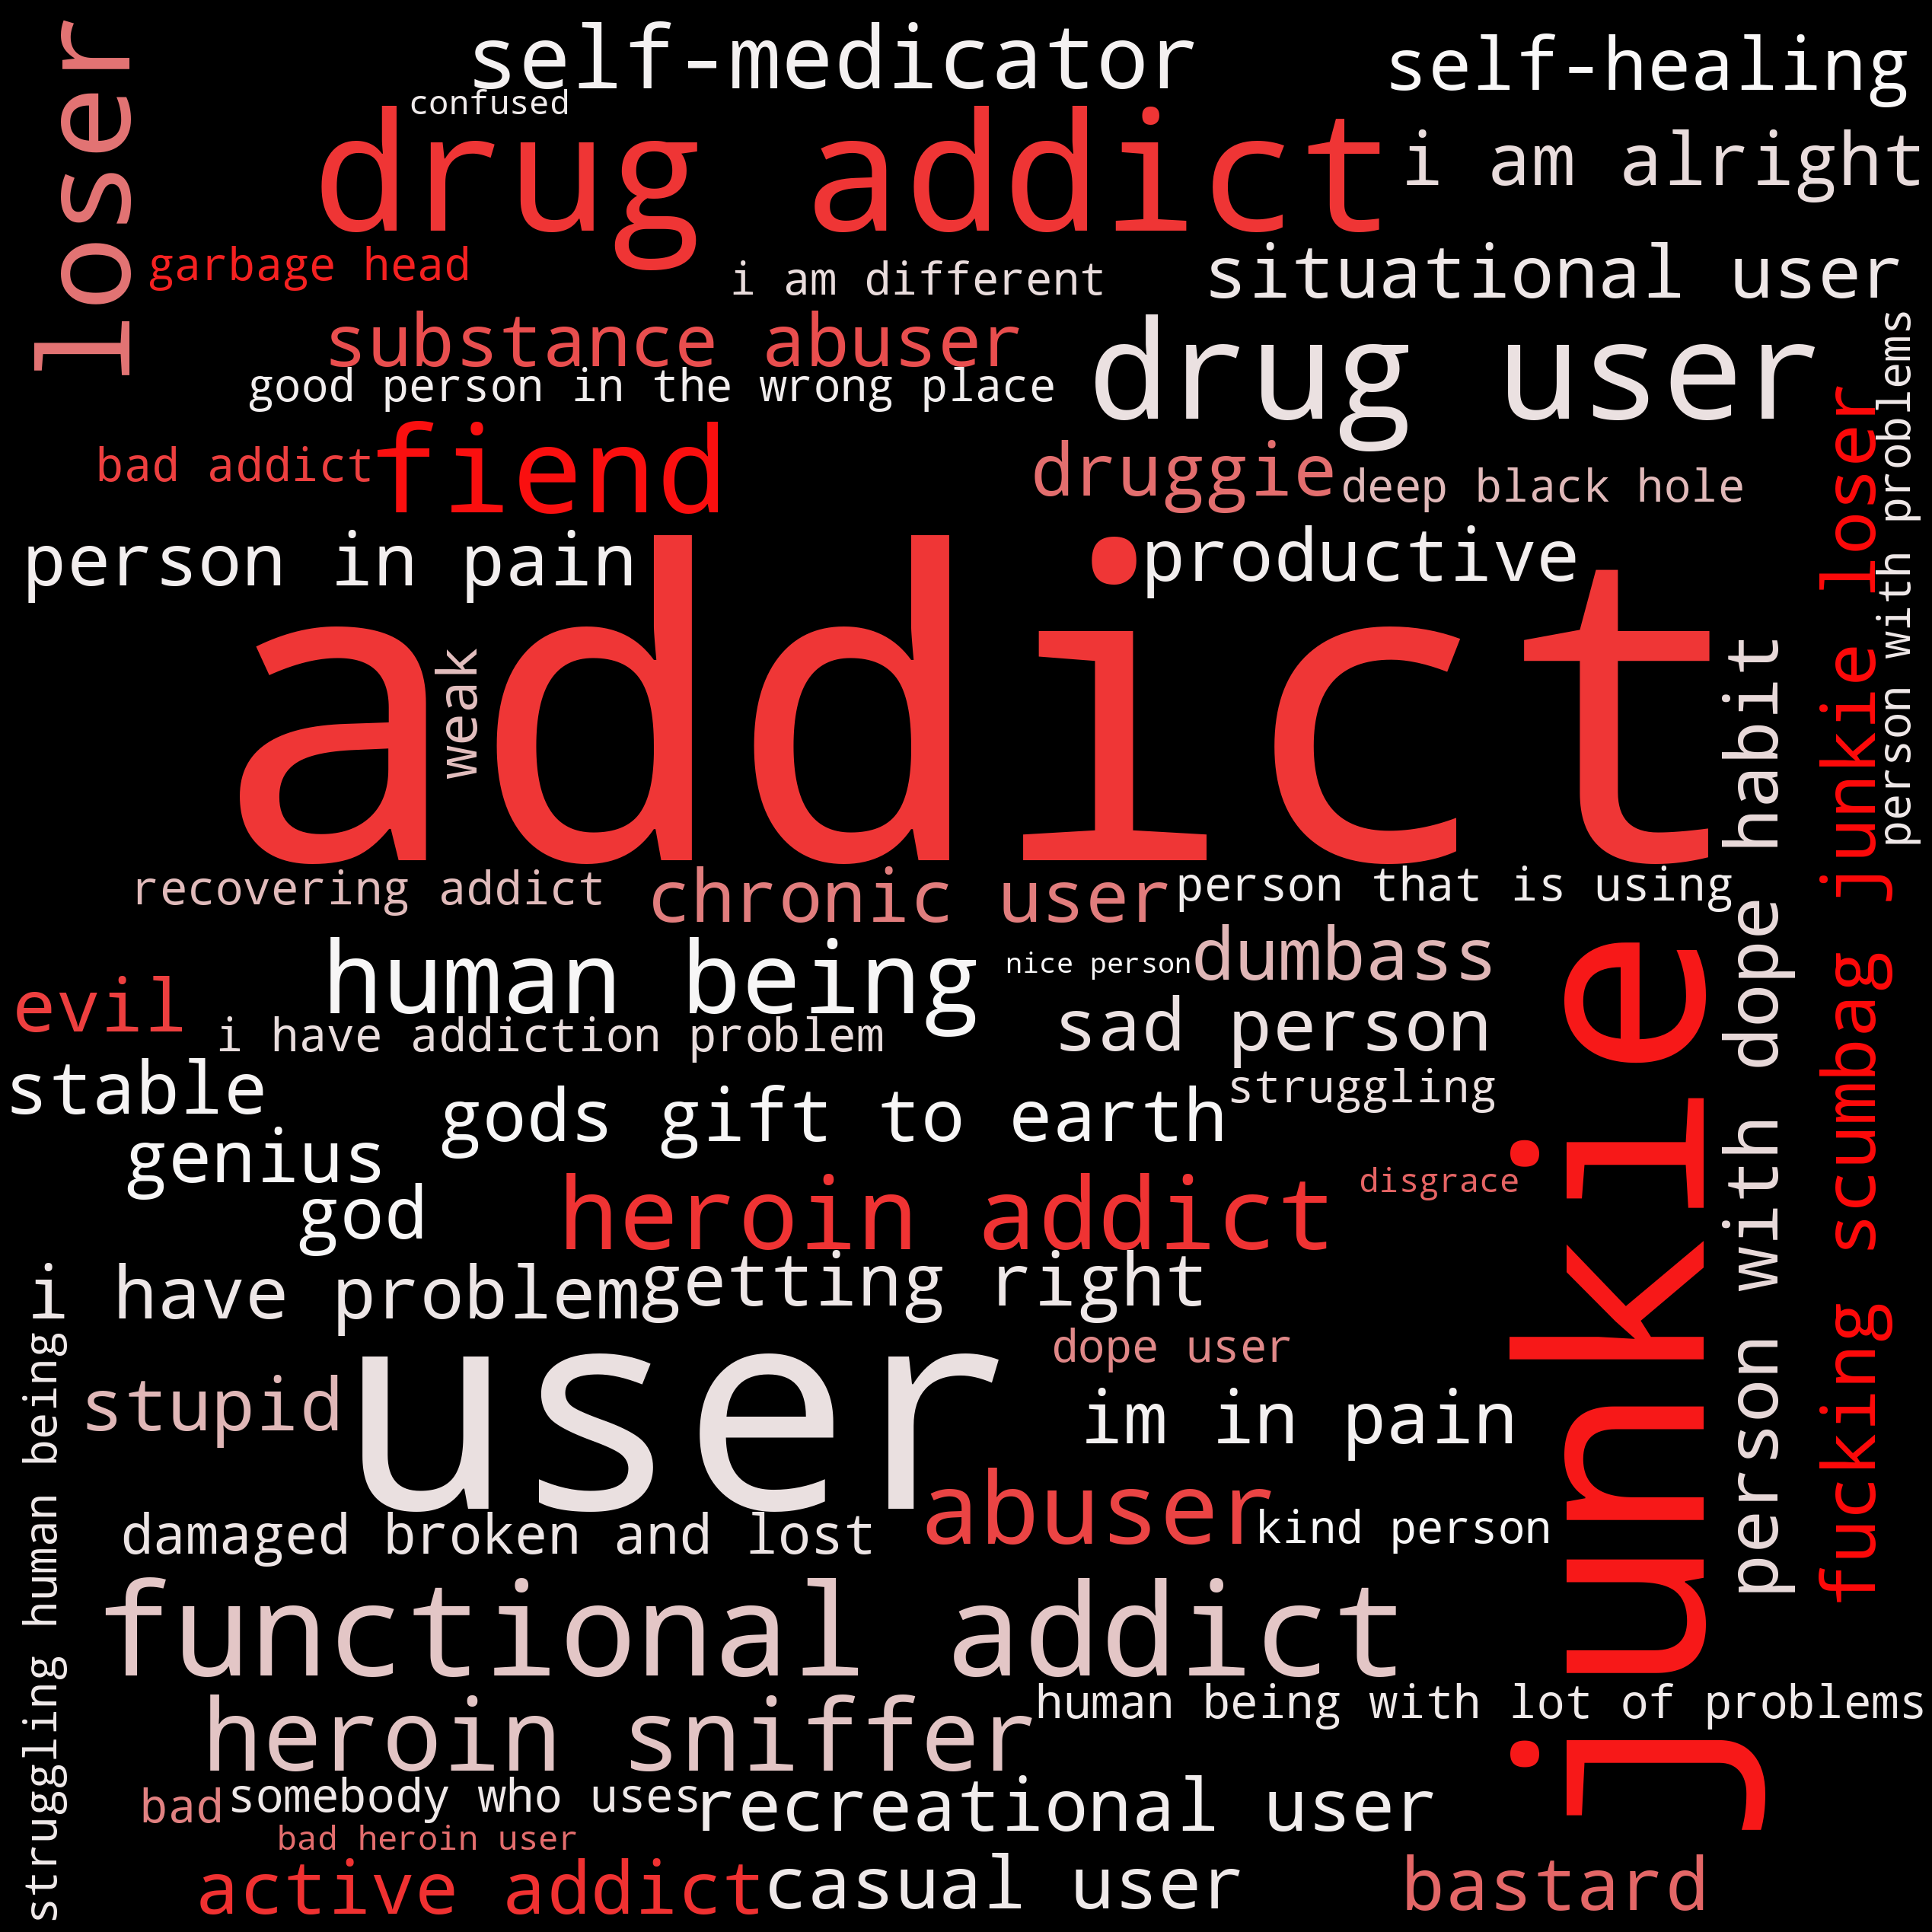

In [31]:
d = pd.read_excel(
    str(itow_files / 'terms_sentiments_and_categories.xlsx'),
    sheet_name='mappings'
)

_word_to_score_dict = extract_dict(
    d[['expression', 'sentiment']].dropna(), 'expression', 'sentiment'
)

# keep only expressions for which we have sentiments
t = {k: v for k, v in dict(a.counts).items() if k in _word_to_score_dict}
print(f"{len(a.counts)=}, {len(_word_to_score_dict)=}, {len(t)=}")

def word_to_score(word):
    return _word_to_score_dict[word] / 100

random_state = 0  # TODO: doesn't actually fix the rendering! But should.

base_color = 'red'

# score_to_color = mk_score_to_color(base_color, min_score=-1, max_score=1)
score_to_color = mk_score_to_color(base_color, min_score=-1, max_score=1)

wc = word_count_for_counts_with_color_control(
    t, word_to_score, score_to_color, random_state=random_state
)
# wc.to_file(f'img/expert_sentiment_scored_{base_color}_{random_state}.pdf')
wc.to_image()


In [51]:
a.color_for_category

{'addict': 'green', 'slang': 'purple', 'user': 'blue', 'other': 'yellow'}

## Contextual word categories

In [92]:
from likert.examples.in_their_own_words import *

`term_category` gives us, for every respondent, what they self-identify as.

In [91]:
term_category = a.term_category
term_category

1       other
2      addict
3       slang
4      addict
5        user
        ...  
202    addict
203    addict
204     other
205    addict
206      user
Name: label, Length: 206, dtype: object

# interlocutor variance

In the survey, we asked the respondents if they use the same self-referential term with: Others who use, Counselors, Doctors, Family, and 12-Step folk. The data is binary 5-tuple per respondent:

In [97]:
s = a.term_interlocutor_data
s

Others who use Counselor Doctor Family 12-Step
1              True      True  False   True    True
2              True      True  False   True    True
3              True      True   True   True     NaN
4              True      True   True   True   False
5             False       NaN  False    NaN     NaN
..              ...       ...    ...    ...     ...
202            True      True   True   True    True
203            True      True   True   True    True
204           False     False  False  False    True
205            True      True   True   True    True
206            True      True   True   True    True

[206 rows x 5 columns]

In [100]:
# from oplot.matrix import heatmap
# t = s.fillna(-1).values.astype(float)
# # change dtype to be float
# # myheatmap(pd.DataFrame(t, index=s.index, columns=s.columns), cmap='RdBu_r', vmin=-1, vmax=1)

# from oplot.matrix import heatmap
# heatmap(t)


In [111]:
%pdb

Automatic pdb calling has been turned OFF


In [114]:
term_mapping.keys()


1       other
2      addict
3       slang
4      addict
5        user
        ...  
202    addict
203    addict
204     other
205    addict
206      user
Name: label, Length: 206, dtype: object

(        Self  Others who use  Counselor  Family  Doctor  12-Step
 other     44              26         25      21      19       19
 addict    97              78         86      69      80       72
 slang     26              14         11      12      10        8
 user      39              30         33      27      32       27
 n        206             148        155     129     141      126,
         Self  Others who use  Counselor  Family  Doctor  12-Step
 other     44              26         25      21      19       19
 addict    97              78         86      69      80       72
 slang     26              14         11      12      10        8
 user      39              30         33      27      32       27)

In [141]:
a = Analysis()
(
    n, missing, other_counts, term_counts, combo_counts, total_counts, 
    interlocutor_transparency_counts, interlocutor_total_counts, all_counts
) = a.multiple_counts.values()

In [143]:
def print_df(df, col_space=14):
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)
    print(df.to_string(col_space=[col_space] * len(df.columns)))
    
print(f"NUM_OF_RESPONDENTS: Number of respondents: {n}")
print("\n")


print("TERM_COUNTS: Term counts (mutually exclusive, so totals to NUM_OF_RESPONDENTS)")
print_df(term_counts)
print("\n")


print(
    """RAW_COUNTS: 
    For each interlocutor category, how many respondents who were 
    "transparent" (i.e. uses the same self-identifying term) with them"""
)
print_df(other_counts)
print("\n")


print(
    "TRANSPARENCY_COUNTS: "
    "Total number of respondents that use the same self-identifying term with interlocutor (category)" 
)
print_df(interlocutor_transparency_counts)
print("\n")


print("MISSING_COUNTS: Missing counts for interlocutor category")
print_df(missing)
print("\n")


print(
    """TOTAL_INTERLOCUTOR_COUNTS: 
    Total number of respondents that responded with interlocutor (category) that is, number of respondents minus missing data.
    """
)
print_df(interlocutor_total_counts)
print("\n")



NUM_OF_RESPONDENTS: Number of respondents: 206


TERM_COUNTS: Term counts (mutually exclusive, so totals to NUM_OF_RESPONDENTS)
                 Self
other              44
addict             97
slang              26
user               39


RAW_COUNTS: 
    For each interlocutor category, how many respondents who were 
    "transparent" (i.e. uses the same self-identifying term) with them
        Others who use      Counselor         Family         Doctor        12-Step
addict              78             86             69             80             72
other               26             25             21             19             19
slang               14             11             12             10              8
user                30             33             27             32             27


TRANSPARENCY_COUNTS: Total number of respondents that use the same self-identifying term with interlocutor (category)
                            n
Others who use            148
Counselor     

In [144]:
interlocutor_transparency_counts / interlocutor_total_counts

Others who use    0.718447
Counselor         0.759804
Family            0.651515
Doctor            0.691176
12-Step           0.673797
dtype: float64

In [145]:

print(
    """TERM_PROPORTIONS: 
        Proportion (and 95% confidence interval) of "respondent category" -- that is, who self-identify with given term.
        Interpretation of Addict entry: 47.09% of respondents self-identify with the term "addict".
        """
)
t = proportion_with_confint(
    pd.DataFrame(term_counts), 
    pd.Series(index=term_counts.index, 
              data=[n] * len(term_counts))
)
print_df(t)
print("\n")

print(
    """TRANSPARENCY_PROPORTIONS: 
        Proportion (and 95% confidence interval) of respondents that are transparent with given interlocutor
        Interpretation of Counselor entry: 75.98% of respondents use the same term with their counselor 
        that they use to self-identify.
        """
)
t = proportion_with_confint(
    pd.DataFrame(interlocutor_transparency_counts), 
    interlocutor_total_counts)
print_df(t)
print("\n")

print(
    """INTERLOCUTOR_TRANSPARENCY_PROPORTIONS: 
        Interpretation of (Addict, Counselor) cell; 88.66% of respondents that self-identify as addicts use the same term
        with their counselors.
        """
)
t = proportion_with_confint(other_counts, term_counts)
print_df(t)
print("\n")


print(
    """TERM_TRANSPARENCY_PROPORTIONS:
    Proportion (and 95% confidence interval) of respondent CATEGORY that is transparent with interlocutor category. Sums to 100%.
    Interpretation of (Addict, Counselor) cell; 55.48% of respondents that are transparent with their counselors self-identify as addicts.
    """
)
t = proportion_with_confint(other_counts, interlocutor_transparency_counts)
print_df(t)
print("\n")


# print(
#     """TERM_RESPONSE_PROPORTIONS: 
#     Proportion (and 95% confidence interval) with respect to number of respondents that gave an answer for interlocutor class.
#     Interpretation of (Addict, Counselor) cell; 42.16% of respondents (who gave an answer for said question)
#     are transparent with their counselor.
#     """
# )
# t = proportion_with_confint(other_counts, interlocutor_total_counts)
# print_df(t)
# print("\n")

TERM_PROPORTIONS: 
        Proportion (and 95% confidence interval) of "respondent category" -- that is, who self-identify with given term.
        Interpretation of Addict entry: 47.09% of respondents self-identify with the term "addict".
        
                       Self
other   21.36% (16.0-27.6%)
addict  47.09% (40.1-54.1%)
slang    12.62% (8.4-17.9%)
user    18.93% (13.8-25.0%)


TRANSPARENCY_PROPORTIONS: 
        Proportion (and 95% confidence interval) of respondents that are transparent with given interlocutor
        Interpretation of Counselor entry: 75.98% of respondents use the same term with their counselor 
        that they use to self-identify.
        
                                  n
Others who use  71.84% (65.2-77.9%)
Counselor       75.98% (69.5-81.7%)
Family          65.15% (58.1-71.8%)
Doctor          69.12% (62.3-75.4%)
12-Step         67.38% (60.2-74.0%)


INTERLOCUTOR_TRANSPARENCY_PROPORTIONS: 
        Interpretation of (Addict, Counselor) cell; 88.66% of

In [146]:
from statsmodels.stats.proportion import proportions_ztest, proportions_ztost


### heatmaps

In [161]:
term_order = ['user', 'slang', 'addict', 'other']
interloc_order_w_self = ['Self', 'Others who use', 'Counselor', 'Family', 'Doctor', '12-Step']
interloc_order = ['Others who use', 'Counselor', 'Family', 'Doctor', '12-Step']

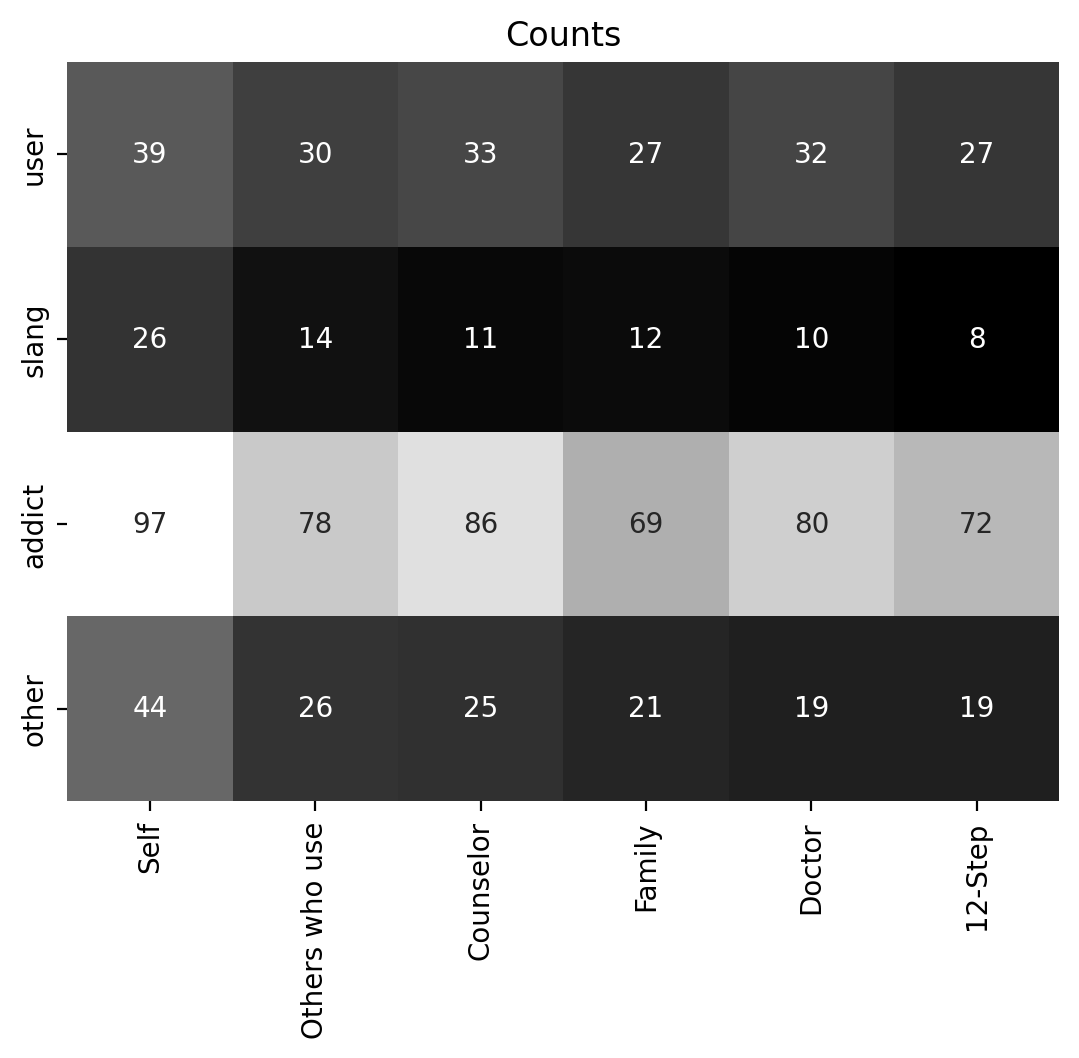

In [162]:
from functools import partial, wraps
import seaborn as sns
from i2 import Pipe

_heatmap = partial(sns.heatmap, annot=True, cbar=False)

@wraps(sns.heatmap)
def myheatmap(*args, fmt="d", cmap='gray', **kwargs):
    plt.xticks(rotation=90);
    return _heatmap(*args, **kwargs, cmap=cmap, fmt=fmt)

myheatmap(combo_counts.loc[term_order][interloc_order_w_self]); plt.title("Counts");

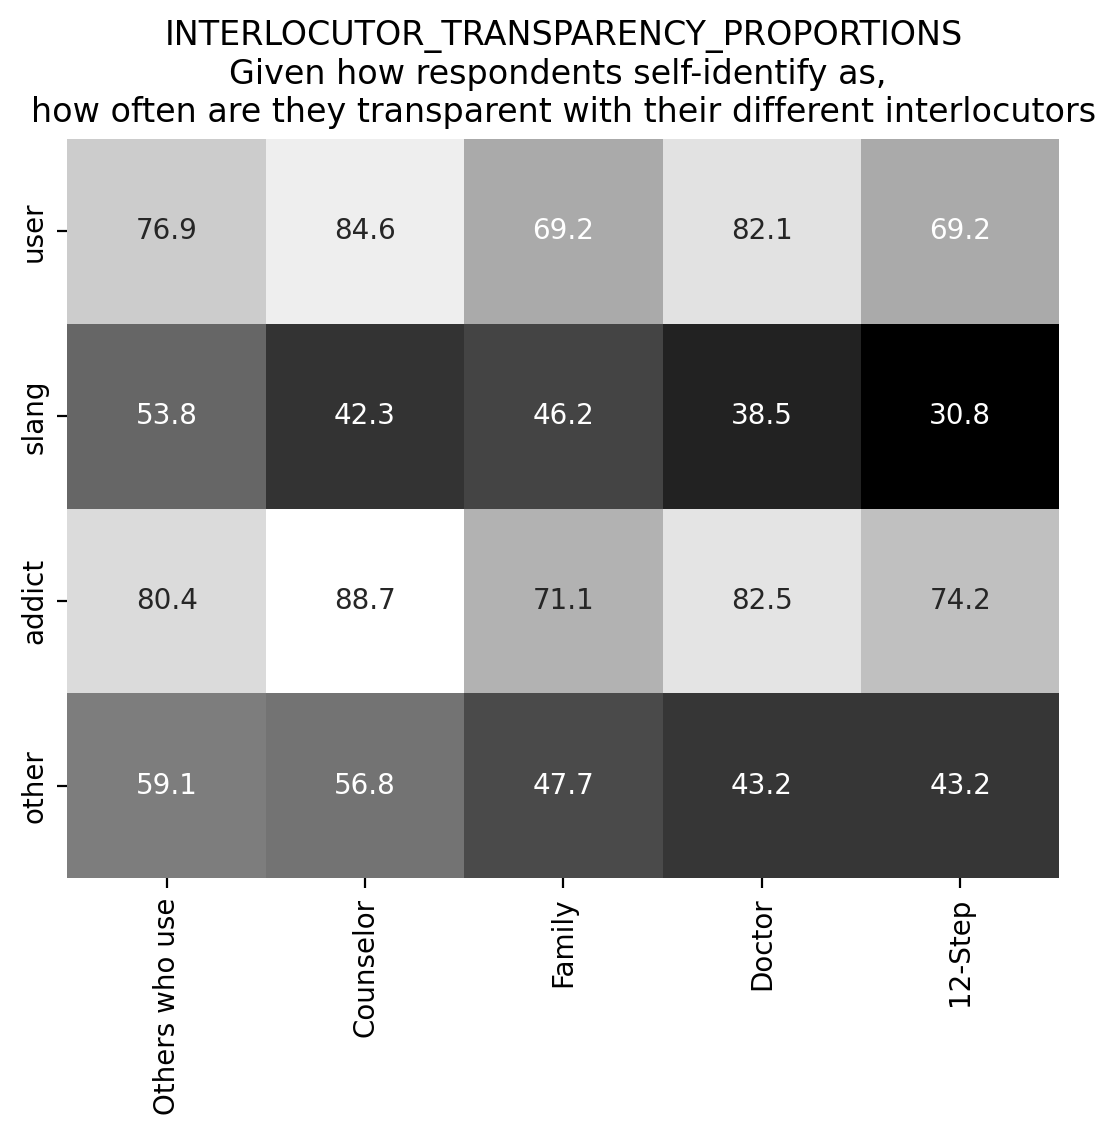

In [163]:
t, tt = proportion_and_confint(other_counts, term_counts)
t *= 100
myheatmap(t.loc[term_order][interloc_order], fmt=".1f"); 
plt.title(
    "INTERLOCUTOR_TRANSPARENCY_PROPORTIONS\n"
    "Given how respondents self-identify as, \n"
    "how often are they transparent with their different interlocutors"
);
# For example, 80.4% of respondents that self-identify as addicts are
#  "transparent" (meaning use the same term) with their counselors


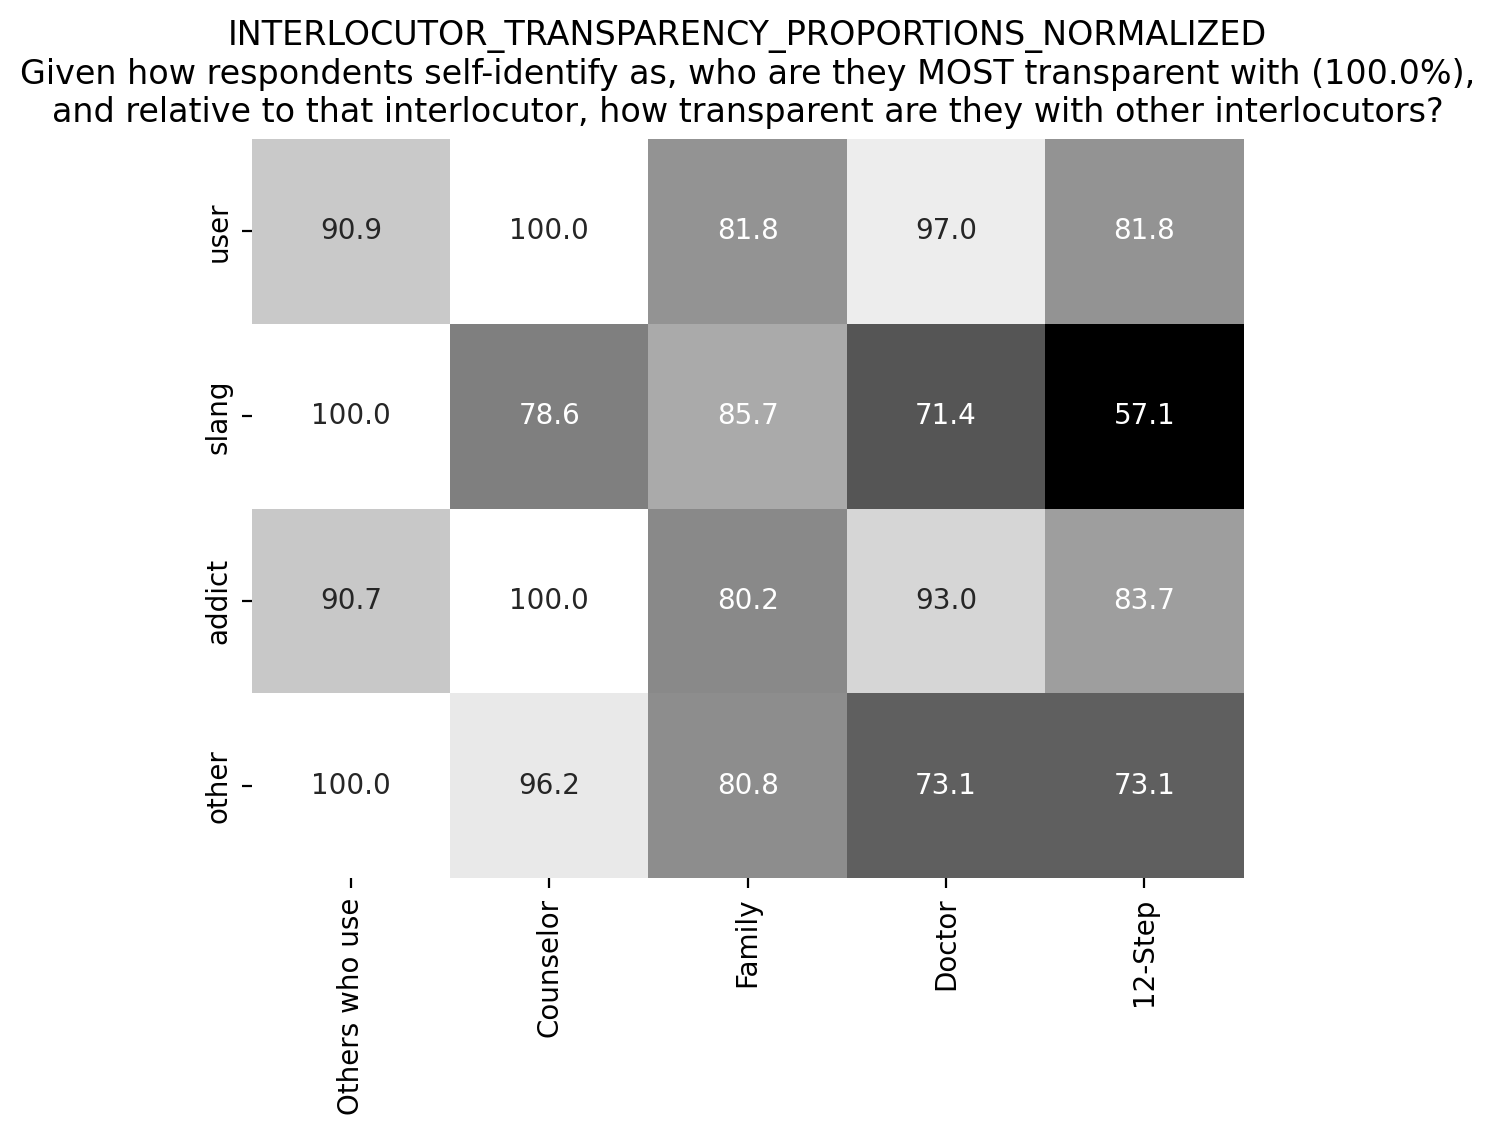

In [165]:
t, tt = proportion_and_confint(other_counts, term_counts)
t = auto_divide(t, t.max(axis=1))
t *= 100
myheatmap(t.loc[term_order][interloc_order], fmt=".1f");
plt.title(
    "INTERLOCUTOR_TRANSPARENCY_PROPORTIONS_NORMALIZED\n"
    "Given how respondents self-identify as, who are they MOST transparent with (100.0%),\n"
    "and relative to that interlocutor, how transparent are they with other interlocutors?"
);

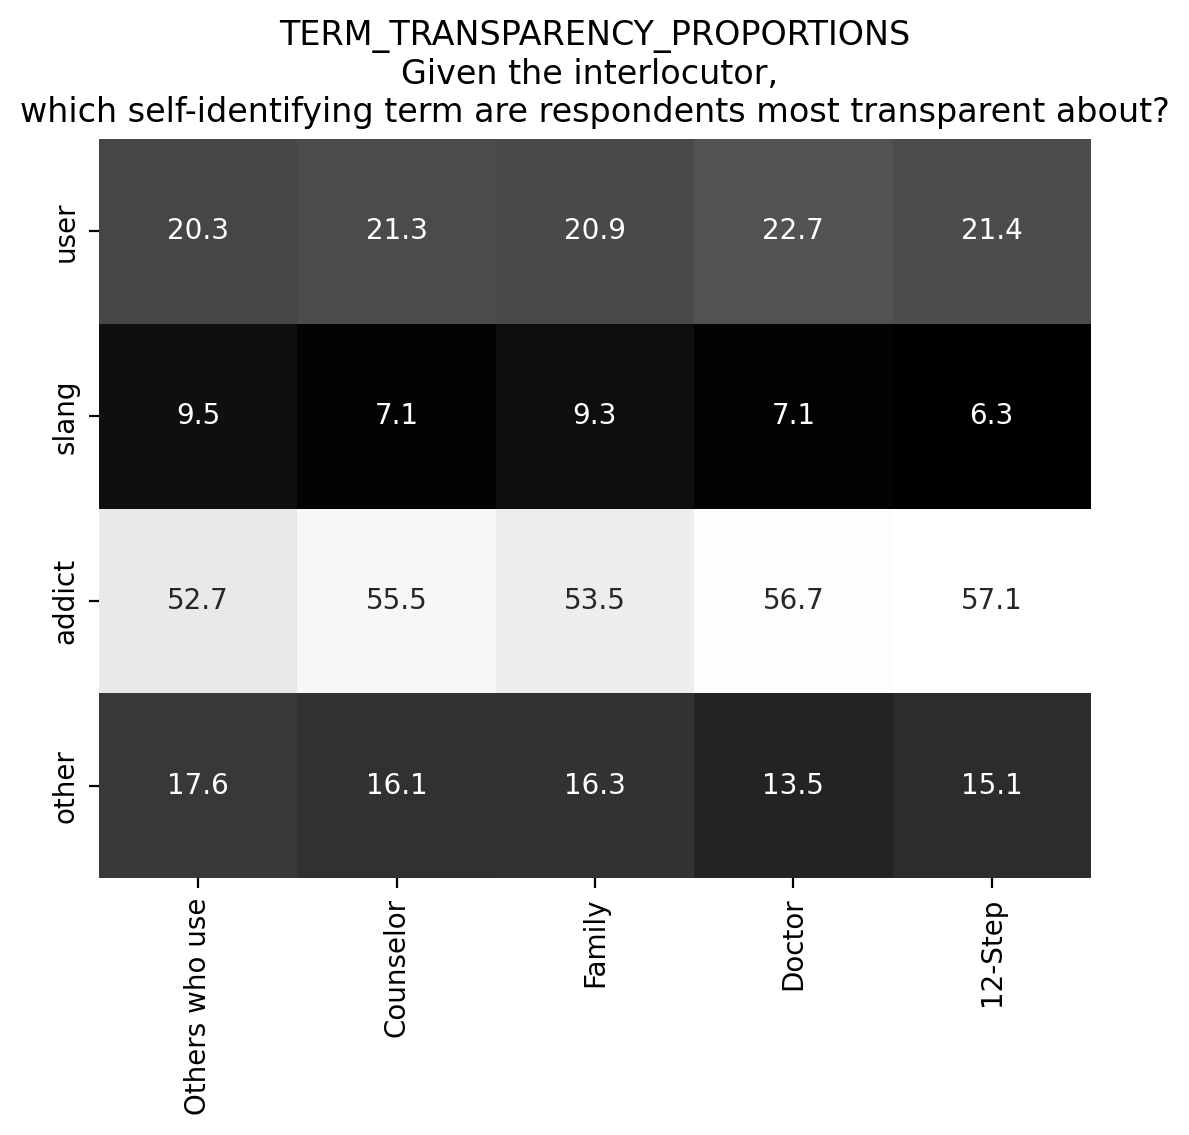

In [166]:
t, tt = proportion_and_confint(other_counts, interlocutor_transparency_counts)
t *= 100
myheatmap(t.loc[term_order][interloc_order], fmt=".1f"); 
plt.title(
    "TERM_TRANSPARENCY_PROPORTIONS\n"
    "Given the interlocutor, \n"
    "which self-identifying term are respondents most transparent about?"
);

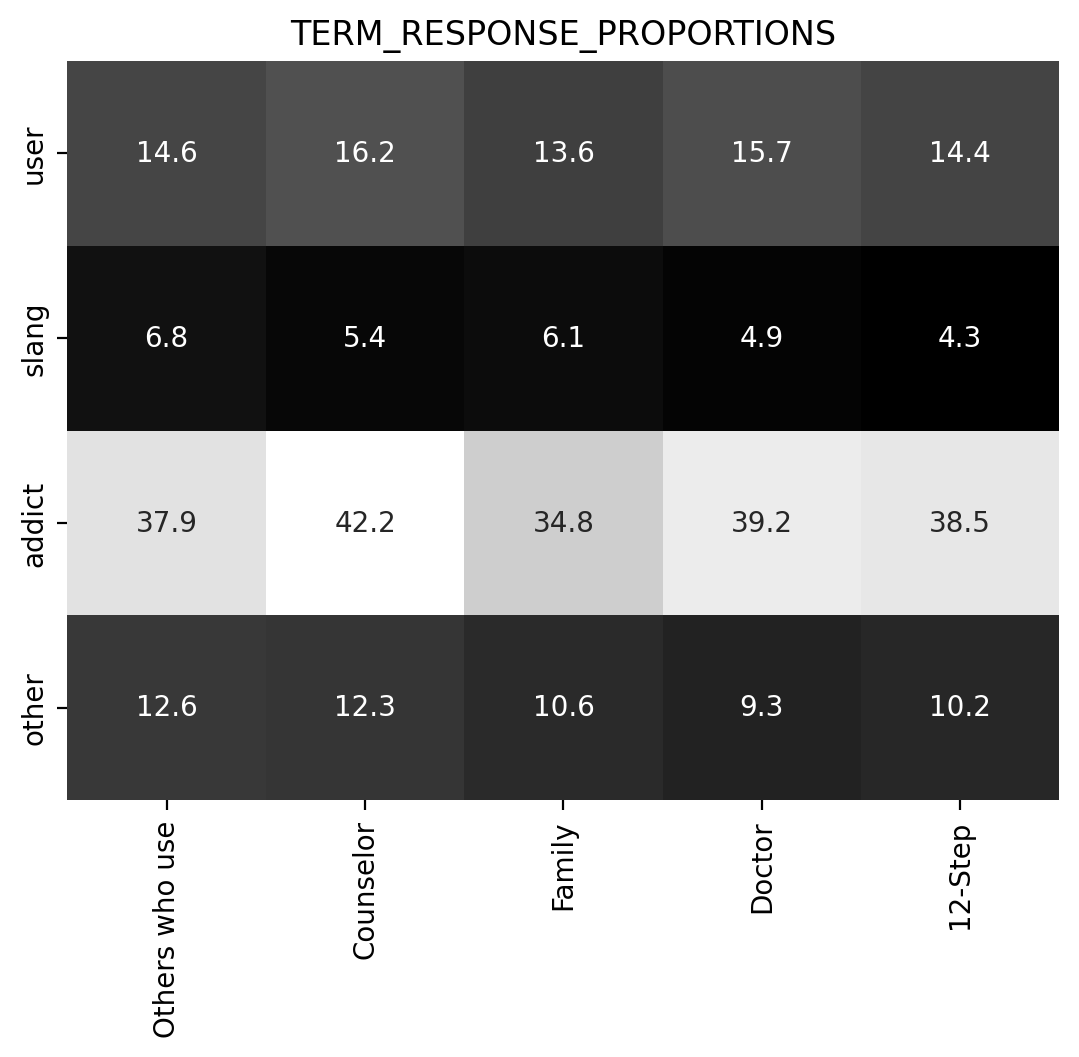

In [167]:
t, tt = proportion_and_confint(other_counts, interlocutor_total_counts)
t *= 100
myheatmap(t.loc[term_order][interloc_order], fmt=".1f"); 
plt.title(
    "TERM_RESPONSE_PROPORTIONS"
);

## Labels

In [7]:
q3_cols = data.columns[[(
    c.startswith('Q3') 
    and not c.endswith('_TEXT') 
    and not c.endswith('_13'))
    for c in data.columns]]
q3_cols

Index(['Q3_1', 'Q3_2', 'Q3_3', 'Q3_4', 'Q3_5', 'Q3_6', 'Q3_7', 'Q3_8', 'Q3_9',
       'Q3_10', 'Q3_11', 'Q3_12'],
      dtype='object')

In [8]:
len(q3_cols)  # 12 categories! Ha! 12-steps!

12

In [9]:
q3_questions = list(map(questions.__getitem__, q3_cols))
print(q3_questions[0])  # just to print an example

3. If
you could choose how other people refer to you, which of the below terms would
you prefer?

Score each label with a number from  1 (‘I would never want to be called this’) to
7 (‘I would prefer to be called this’). - Heroin addict


In [10]:
labels = list(map(extract_end_of_large_question, q3_questions))
labels

['Heroin addict',
 'Heroin-dependent',
 'Heroin abuser',
 'Heroin misuser',
 'Heroin user',
 'Person with heroin addiction',
 'Person with heroin dependence',
 'Person who abuses heroin',
 'Person who uses heroin',
 'Person addicted to heroin',
 'Person with heroin problem',
 'Person who uses drugs']

In [11]:
max_q3 = list(map(max, data[q3_cols]))

In [14]:
# Get q3 data as int or nan (orig is str or missing)
d = data[q3_cols].applymap(lambda x: int(x) if isinstance(x, str) else x)
d.columns = labels
d

Couldn't import flair: No module named 'flair'


Heroin addict  Heroin-dependent  Heroin abuser  Heroin misuser  \
1                3               5.0              5             7.0   
2                2               1.0              1             2.0   
3                7               7.0              4             1.0   
4                4               3.0              1             1.0   
5                1               1.0              1             1.0   
..             ...               ...            ...             ...   
202              1               1.0              1             1.0   
203              1               1.0              1             1.0   
204              1               6.0              6             1.0   
205              3               3.0              3             3.0   
206              3               3.0              1             1.0   

     Heroin user  Person with heroin addiction  Person with heroin dependence  \
1              7                             7                              7   
2              2                             1                              2   
3              7                             7                              7   
4              7                             4                              2   
5              1                             1                              1   
..           ...                           ...                            ...   
202            4                             1                              1   
203            1                             1                              1   
204            5                             6                              6   
205            3                             5                              4   
206            6                             6                              6   

     Person who abuses heroin  Person who uses heroin  \
1                         7.0                       7   
2                         2.0                       7   
3                         1.0                       7   
4                         1.0                       7   
5                         1.0                       4   
..                        ...                     ...   
202                       1.0                       4   
203                       1.0                       1   
204                       6.0                       6   
205                       2.0                       3   
206                       1.0                       7   

     Person addicted to heroin  Person with heroin problem  \
1                            3                         6.0   
2                            2                         3.0   
3                            7                         1.0   
4                            5                         1.0   
5                            3                         3.0   
..                         ...                         ...   
202                          4                         4.0   
203                          1                         1.0   
204                          6                         6.0   
205                          3                         5.0   
206                          6                         7.0   

     Person who uses drugs  
1                      7.0  
2                      7.0  
3                      7.0  
4                      7.0  
5                      7.0  
..                     ...  
202                    2.0  
203                    1.0  
204                    6.0  
205                    1.0  
206                    7.0  

[206 rows x 12 columns]

In [15]:
d

Heroin addict  Heroin-dependent  Heroin abuser  Heroin misuser  \
1                3               5.0              5             7.0   
2                2               1.0              1             2.0   
3                7               7.0              4             1.0   
4                4               3.0              1             1.0   
5                1               1.0              1             1.0   
..             ...               ...            ...             ...   
202              1               1.0              1             1.0   
203              1               1.0              1             1.0   
204              1               6.0              6             1.0   
205              3               3.0              3             3.0   
206              3               3.0              1             1.0   

     Heroin user  Person with heroin addiction  Person with heroin dependence  \
1              7                             7                              7   
2              2                             1                              2   
3              7                             7                              7   
4              7                             4                              2   
5              1                             1                              1   
..           ...                           ...                            ...   
202            4                             1                              1   
203            1                             1                              1   
204            5                             6                              6   
205            3                             5                              4   
206            6                             6                              6   

     Person who abuses heroin  Person who uses heroin  \
1                         7.0                       7   
2                         2.0                       7   
3                         1.0                       7   
4                         1.0                       7   
5                         1.0                       4   
..                        ...                     ...   
202                       1.0                       4   
203                       1.0                       1   
204                       6.0                       6   
205                       2.0                       3   
206                       1.0                       7   

     Person addicted to heroin  Person with heroin problem  \
1                            3                         6.0   
2                            2                         3.0   
3                            7                         1.0   
4                            5                         1.0   
5                            3                         3.0   
..                         ...                         ...   
202                          4                         4.0   
203                          1                         1.0   
204                          6                         6.0   
205                          3                         5.0   
206                          6                         7.0   

     Person who uses drugs  
1                      7.0  
2                      7.0  
3                      7.0  
4                      7.0  
5                      7.0  
..                     ...  
202                    2.0  
203                    1.0  
204                    6.0  
205                    1.0  
206                    7.0  

[206 rows x 12 columns]

In [16]:
d.mean()

Heroin addict                    3.077670
Heroin-dependent                 3.526829
Heroin abuser                    2.956311
Heroin misuser                   2.882927
Heroin user                      4.398058
Person with heroin addiction     4.631068
Person with heroin dependence    4.373786
Person who abuses heroin         3.268293
Person who uses heroin           4.805825
Person addicted to heroin        4.665049
Person with heroin problem       4.868293
Person who uses drugs            5.299020
dtype: float64

In [76]:
sample_sizes = (~d.isna()).sum()
sample_sizes

t = {
    'Never': d.apply(lambda x: x == 1).sum() / sample_sizes,
    'Prefer': d.apply(lambda x: x == 7).sum() / sample_sizes, 
    'Mean (std)': list(zip(d.mean(), d.std())),
    'Median': d.median(),
}

t = pd.DataFrame(t)
t.index.name = 'Label'

print(t.to_string(
    col_space=[14] * 4,
    formatters={
        'Never': lambda x: f"{x * 100:.01f}%",
        'Prefer': lambda x: f"{x * 100:.01f}%",
        'Mean (std)': lambda x: f"{x[0] :.02f} ({x[1]:.02f})",
        'Median': lambda x: f"{x:.01f}",
    }
))

                                       Never         Prefer     Mean (std)         Median
Label                                                                                    
Heroin addict                          45.6%          14.6%    3.08 (2.27)            2.5
Heroin-dependent                       36.6%          17.1%    3.53 (2.31)            4.0
Heroin abuser                          49.0%          14.1%    2.96 (2.30)            2.0
Heroin misuser                         45.9%          10.7%    2.88 (2.15)            2.0
Heroin user                            22.8%          28.6%    4.40 (2.33)            5.0
Person with heroin addiction           22.3%          34.5%    4.63 (2.38)            5.0
Person with heroin dependence          24.8%          28.6%    4.37 (2.38)            5.0
Person who abuses heroin               40.0%          16.6%    3.27 (2.32)            3.0
Person who uses heroin                 17.5%          37.4%    4.81 (2.29)            6.0
Person add

In [18]:
# help(pd.DataFrame.to_string)

In [45]:
# Never (score == 1)
never = d.apply(lambda x: x == 1).sum() / len(d)
never.name = 'never'
never

Heroin addict                    0.456311
Heroin-dependent                 0.364078
Heroin abuser                    0.490291
Heroin misuser                   0.456311
Heroin user                      0.228155
Person with heroin addiction     0.223301
Person with heroin dependence    0.247573
Person who abuses heroin         0.398058
Person who uses heroin           0.174757
Person addicted to heroin        0.189320
Person with heroin problem       0.174757
Person who uses drugs            0.111650
Name: never, dtype: float64

In [46]:
# Prefer (score == 7)
prefer = d.apply(lambda x: x == 7).sum() / len(d)
prefer.name = 'prefer'
prefer

Heroin addict                    0.145631
Heroin-dependent                 0.169903
Heroin abuser                    0.140777
Heroin misuser                   0.106796
Heroin user                      0.286408
Person with heroin addiction     0.344660
Person with heroin dependence    0.286408
Person who abuses heroin         0.165049
Person who uses heroin           0.373786
Person addicted to heroin        0.359223
Person with heroin problem       0.398058
Person who uses drugs            0.485437
Name: prefer, dtype: float64

But note that "never" and "prefer" do not mean "least favorite" and "most favorite".

Indeed, some respondents' score do not stretch from 1 to 7 inclusive.

In [137]:
pd.Series(Counter(d.apply(np.min, axis=1))).sort_values(ascending=False)

1.0    159
3.0     15
4.0     12
2.0      9
7.0      5
6.0      4
5.0      2
dtype: int64

In [138]:
pd.Series(Counter(d.apply(np.max, axis=1))).sort_values(ascending=False)

7.0    152
6.0     15
5.0     14
4.0     11
3.0      7
2.0      4
1.0      3
dtype: int64

## Comparing to prior work

Here I want to compare our results to the results of prior work (reference?) shown below:


<img width="937" alt="Table 1 P S" src="https://user-images.githubusercontent.com/1906276/213404474-d2705cc6-d436-4e81-8f6a-04a86c462476.png">


First, I needed to extract the actual numbers of this table. I used https://www.extracttable.com/ and copy/pasted into a variable that I then parse and make into a pandas dataframe.

In [56]:
import io
import pandas as pd

# Note: We removed the first line: "n (%)	n (%)	Continuous (1-7)	"
prior_work_table = """
Label	% Never (1)	% Prefer (7)b	Mean (+SD)	Median
Heroin addict	44 (17.1%)	107 (41.6%)	4.85 (2.23)	5
Heroin-dependent	49 (19.1%)	91 (35.4%)	4.63 (2.22)	5
Heroin abuser	48 (18.7%)	82 (31.9%)	4.53 (2.19)	4
Heroin misuser	61 (23.7%)	77 (30.0%)	4.23 (2.30)	4
Heroin user	37 (14.4%)	97 (37.7%)	4.86 (2.12)	5
Person with heroin addiction	27 (10.5%)	126 (49.0%)	5.28 (2.02)	6
Person with heroin dependence	37 (14.4%)	109 (42.4%)	5.01 (2.16)	6
Person who abuses heroin	46 (17.9%)	95 (37.0%)	4.74 (2.20)	5
Person who uses heroin	28 (10.9%)	113 (44.0%)	5.16 (2.01)	6
Person addicted to heroin	33 (12.8%)	113 (44.0%)	5.13 (2.08)	6
Person with heroin problem	28 (10.9%)	119 (46.3%)	5.20 (2.05)	6
Person who uses drugs	19 (7.5%)	142 (55.3%)	5.65 (1.92)	7
"""
prior_work_table = pd.read_csv(io.StringIO(prior_work_table), sep='\t')
prior_work_table = prior_work_table.set_index('Label')
prior_work_table

% Never (1) % Prefer (7)b   Mean (+SD)  Median
Label                                                                       
Heroin addict                  44 (17.1%)   107 (41.6%)  4.85 (2.23)       5
Heroin-dependent               49 (19.1%)    91 (35.4%)  4.63 (2.22)       5
Heroin abuser                  48 (18.7%)    82 (31.9%)  4.53 (2.19)       4
Heroin misuser                 61 (23.7%)    77 (30.0%)  4.23 (2.30)       4
Heroin user                    37 (14.4%)    97 (37.7%)  4.86 (2.12)       5
Person with heroin addiction   27 (10.5%)   126 (49.0%)  5.28 (2.02)       6
Person with heroin dependence  37 (14.4%)   109 (42.4%)  5.01 (2.16)       6
Person who abuses heroin       46 (17.9%)    95 (37.0%)  4.74 (2.20)       5
Person who uses heroin         28 (10.9%)   113 (44.0%)  5.16 (2.01)       6
Person addicted to heroin      33 (12.8%)   113 (44.0%)  5.13 (2.08)       6
Person with heroin problem     28 (10.9%)   119 (46.3%)  5.20 (2.05)       6
Person who uses drugs           19 (7.5%)   142 (55.3%)  5.65 (1.92)       7

In [64]:
p = re.compile('(?P<count>\d+) \((?P<proportion>[\d\.]+)%\)')

def parse_out_count_and_proportion_from_str(string):
    w = p.match(string).groupdict()
    w = {'p2': float(w['proportion']) / 100, 'n2': int(w['count'])} 
    return w

def parse_out_count_and_proportion_from_strings(strings):
    return pd.DataFrame(
        list(map(parse_out_count_and_proportion_from_str, strings))
    )

never2 = parse_out_count_and_proportion_from_strings(
    prior_work_table['% Never (1)']
)
never2.index = prior_work_table.index

prefer2 = parse_out_count_and_proportion_from_strings(
    prior_work_table['% Prefer (7)b']
)
prefer2.index = prior_work_table.index

# Note: never2 and prefer2 have nothing to do with n2 and p2
# n2 and p2 is supposed to mean "number of persons in sample" and p2 "proportion"

never2

p2  n2
Label                                   
Heroin addict                  0.171  44
Heroin-dependent               0.191  49
Heroin abuser                  0.187  48
Heroin misuser                 0.237  61
Heroin user                    0.144  37
Person with heroin addiction   0.105  27
Person with heroin dependence  0.144  37
Person who abuses heroin       0.179  46
Person who uses heroin         0.109  28
Person addicted to heroin      0.128  33
Person with heroin problem     0.109  28
Person who uses drugs          0.075  19

Now we need to make our table look the same (but with n1 and p1 columns)

In [78]:
NEVER = 1
PREFER = 7

likert_level = NEVER

sample_sizes = (~d.isna()).sum()

t = d.apply(lambda x: x == NEVER).sum()
never1 = pd.DataFrame(
    {'p1': t / sample_sizes, 'n1': sample_sizes}
)

t = d.apply(lambda x: x == PREFER).sum()
prefer1 = pd.DataFrame(
    {'p1': t / sample_sizes, 'n1': sample_sizes}
)

del t

never1

p1   n1
Heroin addict                  0.456311  206
Heroin-dependent               0.365854  205
Heroin abuser                  0.490291  206
Heroin misuser                 0.458537  205
Heroin user                    0.228155  206
Person with heroin addiction   0.223301  206
Person with heroin dependence  0.247573  206
Person who abuses heroin       0.400000  205
Person who uses heroin         0.174757  206
Person addicted to heroin      0.189320  206
Person with heroin problem     0.175610  205
Person who uses drugs          0.112745  204

In [97]:
never = pd.concat([never1, never2], axis=1)
prefer = pd.concat([prefer1, prefer2], axis=1)

In [98]:
print(never.round(3).to_markdown())

|                               |    p1 |   n1 |    p2 |   n2 |
|:------------------------------|------:|-----:|------:|-----:|
| Heroin addict                 | 0.456 |  206 | 0.171 |   44 |
| Heroin-dependent              | 0.366 |  205 | 0.191 |   49 |
| Heroin abuser                 | 0.49  |  206 | 0.187 |   48 |
| Heroin misuser                | 0.459 |  205 | 0.237 |   61 |
| Heroin user                   | 0.228 |  206 | 0.144 |   37 |
| Person with heroin addiction  | 0.223 |  206 | 0.105 |   27 |
| Person with heroin dependence | 0.248 |  206 | 0.144 |   37 |
| Person who abuses heroin      | 0.4   |  205 | 0.179 |   46 |
| Person who uses heroin        | 0.175 |  206 | 0.109 |   28 |
| Person addicted to heroin     | 0.189 |  206 | 0.128 |   33 |
| Person with heroin problem    | 0.176 |  205 | 0.109 |   28 |
| Person who uses drugs         | 0.113 |  204 | 0.075 |   19 |


In [99]:
print(prefer.round(3).to_markdown())

|                               |    p1 |   n1 |    p2 |   n2 |
|:------------------------------|------:|-----:|------:|-----:|
| Heroin addict                 | 0.146 |  206 | 0.416 |  107 |
| Heroin-dependent              | 0.171 |  205 | 0.354 |   91 |
| Heroin abuser                 | 0.141 |  206 | 0.319 |   82 |
| Heroin misuser                | 0.107 |  205 | 0.3   |   77 |
| Heroin user                   | 0.286 |  206 | 0.377 |   97 |
| Person with heroin addiction  | 0.345 |  206 | 0.49  |  126 |
| Person with heroin dependence | 0.286 |  206 | 0.424 |  109 |
| Person who abuses heroin      | 0.166 |  205 | 0.37  |   95 |
| Person who uses heroin        | 0.374 |  206 | 0.44  |  113 |
| Person addicted to heroin     | 0.359 |  206 | 0.44  |  113 |
| Person with heroin problem    | 0.4   |  205 | 0.463 |  119 |
| Person who uses drugs         | 0.49  |  204 | 0.553 |  142 |


In [83]:
from likert.examples.in_their_own_words import (
    compute_stats_on_the_difference_of_proportions_df
)

never_prop_diff_stats = compute_stats_on_the_difference_of_proportions_df(never)
prefer_prop_diff_stats = compute_stats_on_the_difference_of_proportions_df(prefer)

In [84]:
never_prop_diff_stats

p_value  chi_squared   z_score
Heroin addict                  0.000469    12.236888  3.498126
Heroin-dependent               0.019558     5.450933  2.334723
Heroin abuser                  0.000134    14.585764  3.819131
Heroin misuser                 0.001995     9.554315  3.091005
Heroin user                    0.251550     1.314672  1.146592
Person with heroin addiction   0.155585     2.016625  1.420079
Person with heroin dependence  0.169250     1.889571  1.374617
Person who abuses heroin       0.004758     7.969032  2.822947
Person who uses heroin         0.381272     0.766596  0.875555
Person addicted to heroin      0.395506     0.721946  0.849674
Person with heroin problem     0.376086     0.783457  0.885131
Person who uses drugs          0.614347     0.253893  0.503878

In [85]:
prefer_prop_diff_stats

p_value  chi_squared   z_score
Heroin addict                  9.967723e-08    28.380246 -5.327311
Heroin-dependent               5.149601e-04    12.060698 -3.472852
Heroin abuser                  5.229892e-04    12.031858 -3.468697
Heroin misuser                 8.390699e-05    15.468157 -3.932958
Heroin user                    1.133754e-01     2.506529 -1.583202
Person with heroin addiction   8.706160e-03     6.882133 -2.623382
Person with heroin dependence  1.377700e-02     6.066497 -2.463026
Person who abuses heroin       9.401926e-05    15.253161 -3.905530
Person who uses heroin         2.477162e-01     1.336138 -1.155914
Person addicted to heroin      1.567352e-01     2.005446 -1.416138
Person with heroin problem     2.685213e-01     1.224286 -1.106474
Person who uses drugs          2.501855e-01     1.322267 -1.149899

In [95]:
print(never_prop_diff_stats.round(3).to_markdown())

|                               |   p_value |   chi_squared |   z_score |
|:------------------------------|----------:|--------------:|----------:|
| Heroin addict                 |     0     |        12.237 |     3.498 |
| Heroin-dependent              |     0.02  |         5.451 |     2.335 |
| Heroin abuser                 |     0     |        14.586 |     3.819 |
| Heroin misuser                |     0.002 |         9.554 |     3.091 |
| Heroin user                   |     0.252 |         1.315 |     1.147 |
| Person with heroin addiction  |     0.156 |         2.017 |     1.42  |
| Person with heroin dependence |     0.169 |         1.89  |     1.375 |
| Person who abuses heroin      |     0.005 |         7.969 |     2.823 |
| Person who uses heroin        |     0.381 |         0.767 |     0.876 |
| Person addicted to heroin     |     0.396 |         0.722 |     0.85  |
| Person with heroin problem    |     0.376 |         0.783 |     0.885 |
| Person who uses drugs         |     

In [96]:
print(prefer_prop_diff_stats.round(3).to_markdown())

|                               |   p_value |   chi_squared |   z_score |
|:------------------------------|----------:|--------------:|----------:|
| Heroin addict                 |     0     |        28.38  |    -5.327 |
| Heroin-dependent              |     0.001 |        12.061 |    -3.473 |
| Heroin abuser                 |     0.001 |        12.032 |    -3.469 |
| Heroin misuser                |     0     |        15.468 |    -3.933 |
| Heroin user                   |     0.113 |         2.507 |    -1.583 |
| Person with heroin addiction  |     0.009 |         6.882 |    -2.623 |
| Person with heroin dependence |     0.014 |         6.066 |    -2.463 |
| Person who abuses heroin      |     0     |        15.253 |    -3.906 |
| Person who uses heroin        |     0.248 |         1.336 |    -1.156 |
| Person addicted to heroin     |     0.157 |         2.005 |    -1.416 |
| Person with heroin problem    |     0.269 |         1.224 |    -1.106 |
| Person who uses drugs         |     

## More on gauging favorites

The kind of measurement used here (1 to 7, to denote a degree of preference) is called 
likert scale (https://en.wikipedia.org/wiki/Likert_scale). 

Different people project their subjectivity in different ways, 
and one can try to remove some of the measurement variability and interpretation error. 
There's no doubt research on that subject, but we'll just try out something simple here 
to see what different perspective it yields.

To get least and most favorite we can compute the min and max score for every respondent 
and compare their answers to that.




In [281]:
# The min_q3 value will be used to identify (in a relative way) if a term is a favorite
min_q3 = d.apply(np.min, axis=1)
# The max_q3 value will be used to identify (in a relative way) if a term is a favorite
max_q3 = d.apply(np.max, axis=1)

In [282]:
# The perhaps more correct definition of leaste favorite
# (taking least favorite to be the minimum score for respondent)
least_favorite = d.apply(lambda x: x == min_q3).sum() / len(d)
least_favorite.name = 'least_favorite'
least_favorite

Heroin addict                    0.572816
Heroin-dependent                 0.441748
Heroin abuser                    0.572816
Heroin misuser                   0.582524
Heroin user                      0.296117
Person with heroin addiction     0.281553
Person with heroin dependence    0.320388
Person who abuses heroin         0.490291
Person who uses heroin           0.242718
Person addicted to heroin        0.247573
Person with heroin problem       0.237864
Person who uses drugs            0.174757
Name: least_favorite, dtype: float64

In [283]:
# The perhaps more correct definition of favorite
# (taking favorite to be the maximum score for respondent)
favorite = d.apply(lambda x: x == max_q3).sum() / len(d)
favorite.name = 'favorite'
favorite

Heroin addict                    0.194175
Heroin-dependent                 0.218447
Heroin abuser                    0.208738
Heroin misuser                   0.169903
Heroin user                      0.373786
Person with heroin addiction     0.466019
Person with heroin dependence    0.398058
Person who abuses heroin         0.247573
Person who uses heroin           0.490291
Person addicted to heroin        0.495146
Person with heroin problem       0.533981
Person who uses drugs            0.650485
Name: favorite, dtype: float64

In [284]:
convert_to_percentage = lambda x: round(x * 100, 2)

In [285]:
never_and_least_favorite = (
    pd.merge(never, least_favorite, left_index=True, right_index=True)
    .sort_values('never', ascending=False)
    .applymap(convert_to_percentage)
)
never_and_least_favorite

never  least_favorite
Heroin abuser                  49.03           57.28
Heroin addict                  45.63           57.28
Heroin misuser                 45.63           58.25
Person who abuses heroin       39.81           49.03
Heroin-dependent               36.41           44.17
Person with heroin dependence  24.76           32.04
Heroin user                    22.82           29.61
Person with heroin addiction   22.33           28.16
Person addicted to heroin      18.93           24.76
Person who uses heroin         17.48           24.27
Person with heroin problem     17.48           23.79
Person who uses drugs          11.17           17.48

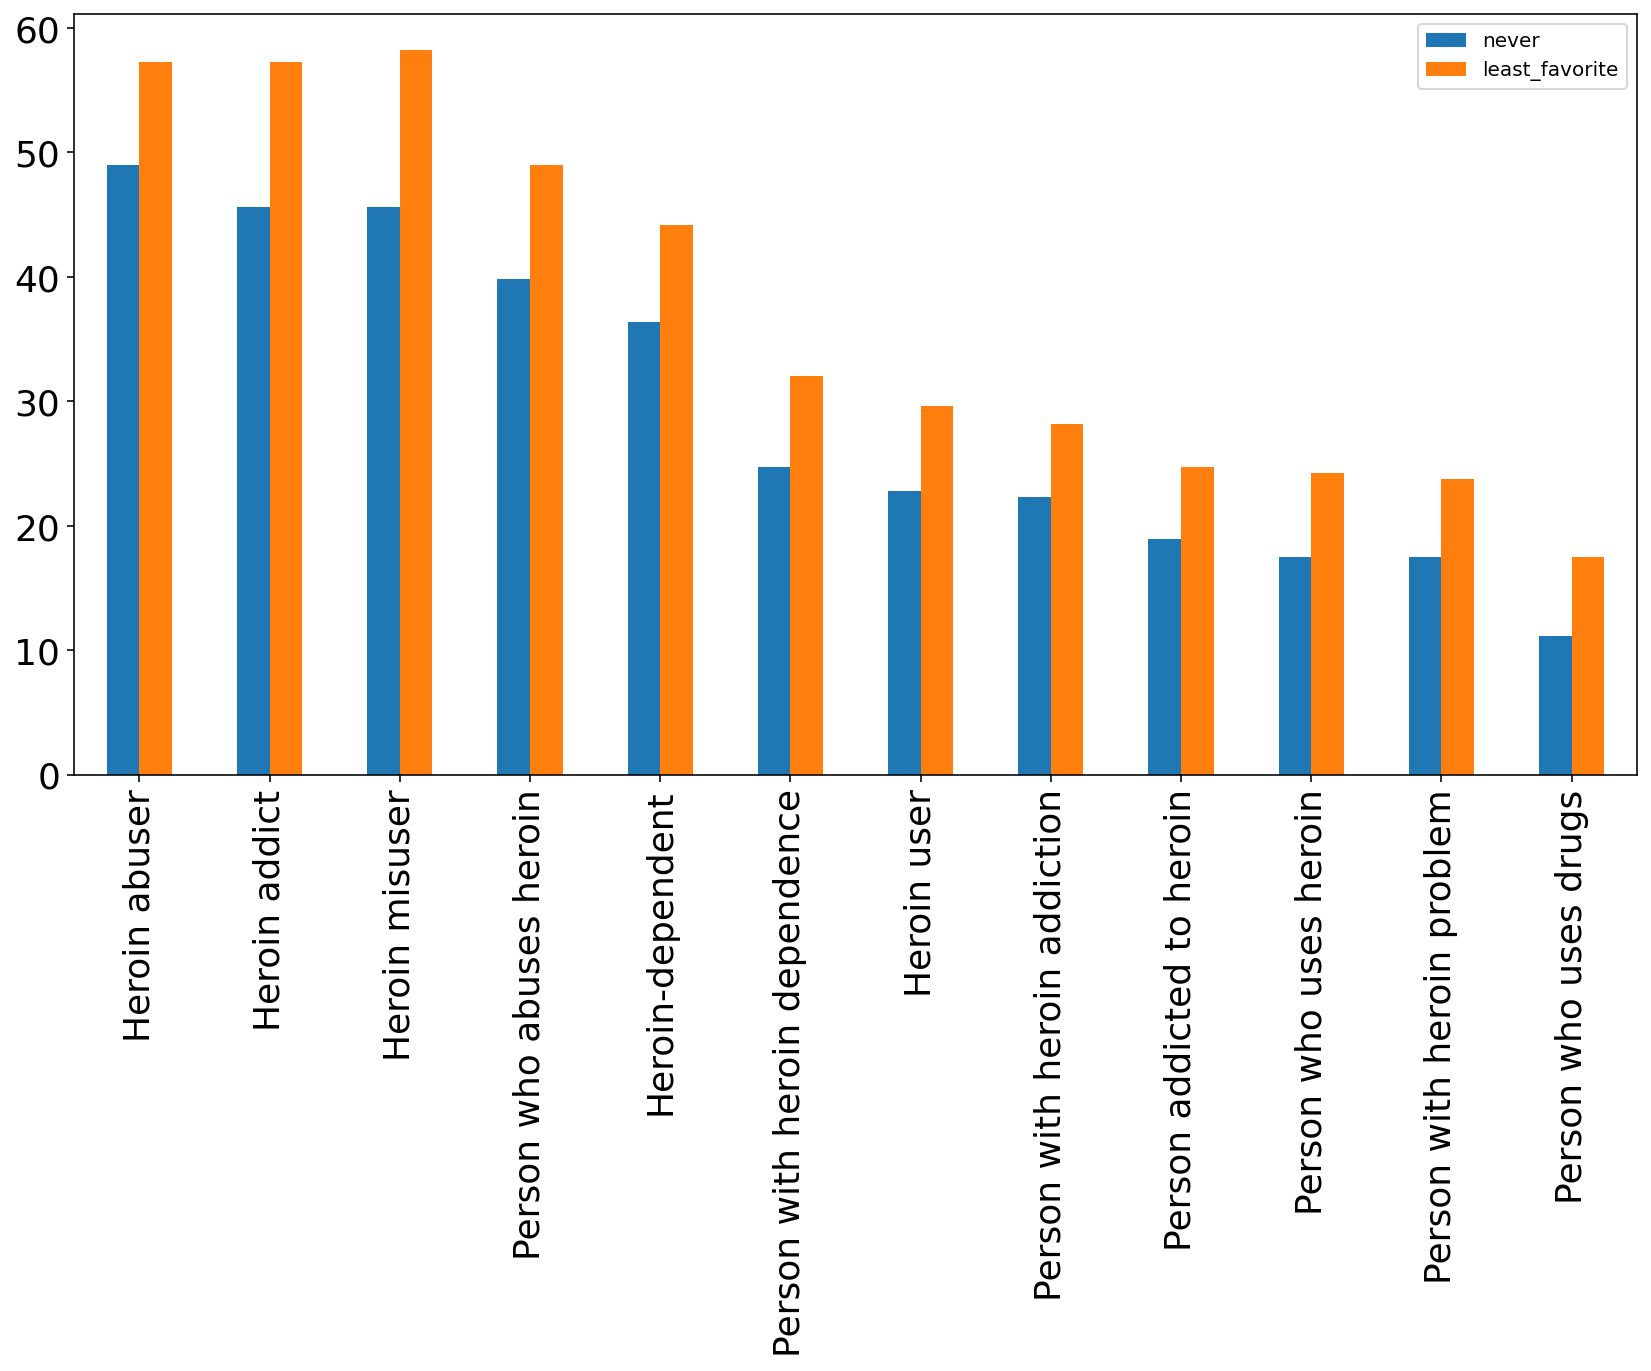

In [286]:
never_and_least_favorite.plot(kind='bar', figsize=(14, 7), fontsize=18);

In [287]:
prefer_and_favorite = (
    pd.merge(prefer, favorite, left_index=True,right_index=True,)
    .sort_values('prefer', ascending=False)
    .applymap(convert_to_percentage)
)
prefer_and_favorite

prefer  favorite
Person who uses drugs           48.54     65.05
Person with heroin problem      39.81     53.40
Person who uses heroin          37.38     49.03
Person addicted to heroin       35.92     49.51
Person with heroin addiction    34.47     46.60
Heroin user                     28.64     37.38
Person with heroin dependence   28.64     39.81
Heroin-dependent                16.99     21.84
Person who abuses heroin        16.50     24.76
Heroin addict                   14.56     19.42
Heroin abuser                   14.08     20.87
Heroin misuser                  10.68     16.99

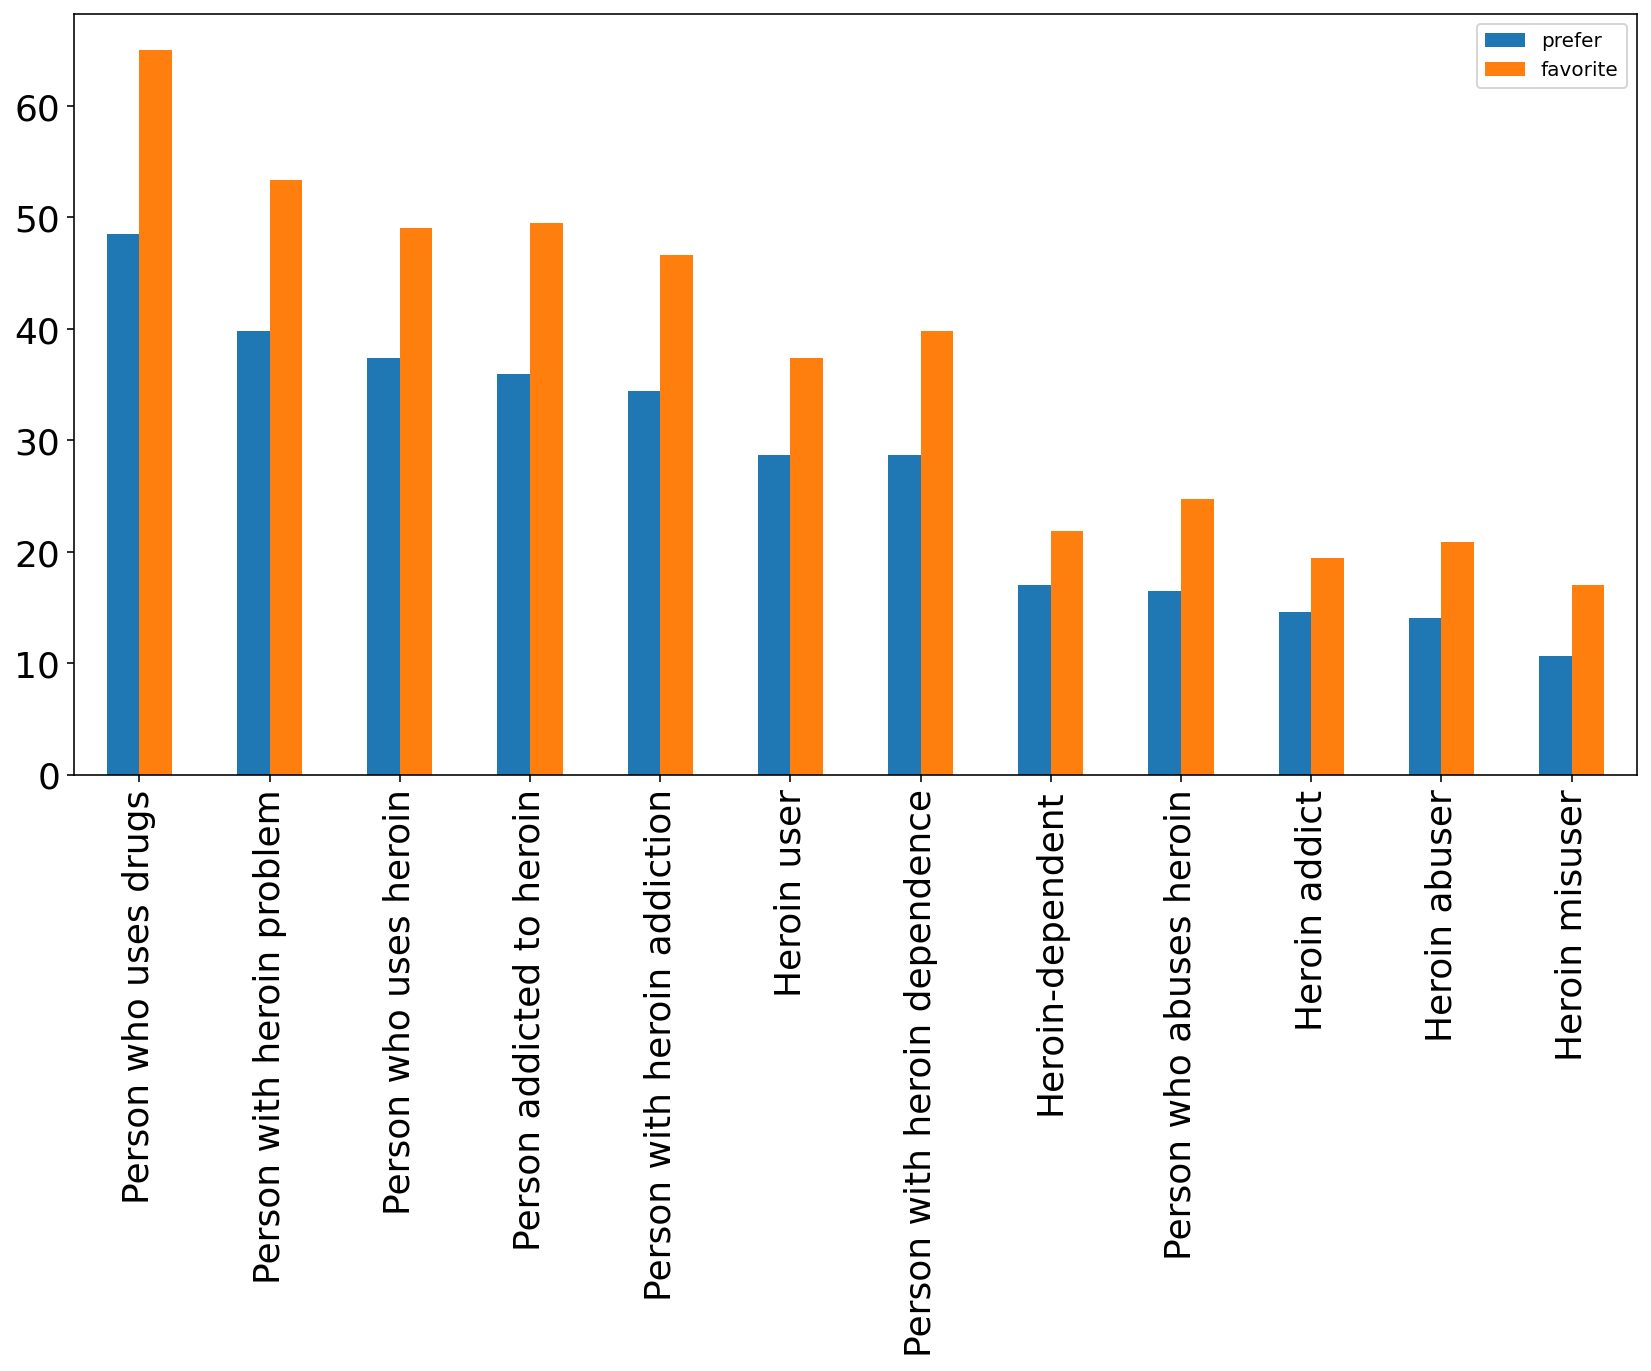

In [303]:
prefer_and_favorite.plot(kind='bar', figsize=(14, 7), fontsize=18);

Treating the ordinal Likert scales as a numerical seems even more problematic, 
but since some may wish to see this, we can humor them...

(Should we also go all the way to adding the standard deviation of the mean (those +/- 2.26) even though 
other distortions such as sample bias and the Likert scale itself probably overshadow those due to estimating a 
population mean with a sample mean? 
I say: Let's not encourage thoughtless quantitative methodology dogma further!)

In [482]:
mean_score = d.mean().apply(lambda x: round(x, 2))
mean_score.name = 'mean'
mean_score

Heroin addict                    3.08
Heroin-dependent                 3.53
Heroin abuser                    2.96
Heroin misuser                   2.88
Heroin user                      4.40
Person with heroin addiction     4.63
Person with heroin dependence    4.37
Person who abuses heroin         3.27
Person who uses heroin           4.81
Person addicted to heroin        4.67
Person with heroin problem       4.87
Person who uses drugs            5.30
Name: mean, dtype: float64

In [483]:
median_score = d.median()
median_score.name = 'median'
median_score

Heroin addict                    2.5
Heroin-dependent                 4.0
Heroin abuser                    2.0
Heroin misuser                   2.0
Heroin user                      5.0
Person with heroin addiction     5.0
Person with heroin dependence    5.0
Person who abuses heroin         3.0
Person who uses heroin           6.0
Person addicted to heroin        5.0
Person with heroin problem       6.0
Person who uses drugs            6.0
Name: median, dtype: float64

In [487]:
pd.concat([
    never.apply(convert_to_percentage), 
    prefer.apply(convert_to_percentage), 
    mean_score, 
    median_score
], axis=1)

never  prefer  mean  median
Heroin addict                   45.6    14.6  3.08     2.5
Heroin-dependent                36.4    17.0  3.53     4.0
Heroin abuser                   49.0    14.1  2.96     2.0
Heroin misuser                  45.6    10.7  2.88     2.0
Heroin user                     22.8    28.6  4.40     5.0
Person with heroin addiction    22.3    34.5  4.63     5.0
Person with heroin dependence   24.8    28.6  4.37     5.0
Person who abuses heroin        39.8    16.5  3.27     3.0
Person who uses heroin          17.5    37.4  4.81     6.0
Person addicted to heroin       18.9    35.9  4.67     5.0
Person with heroin problem      17.5    39.8  4.87     6.0
Person who uses drugs           11.2    48.5  5.30     6.0

### Labels word clouds

What weight should we use to represent the importance of a label? 

Since taking Likert scale values as numerical whose mean and median have some kind of interpretable 
meaning doesn't seem to be a problem for some, we'll be lazy and do the same here, 
summing the scores of the labels to get a weight for each label. 

Obviously, a more careful analysis could be done, but what's the use of over-thinking 
a solution when the bulk of the audience doesn't recognize the very problem!

In [331]:
from collections import defaultdict

def iter_label_and_scores(d):
    for column_name, column_vals in d.items():
        for score in column_vals:
            yield column_name, score
            
def labels_aggregate_score(d):
    stats = defaultdict(int)
    for label, score in iter_label_and_scores(d):
        if isinstance(score, int):
            stats[label] += score
    return pd.Series(stats).sort_values(ascending=False)

labels_aggregate_score(d)

Person who uses heroin           990
Person addicted to heroin        961
Person with heroin addiction     954
Heroin user                      906
Person with heroin dependence    901
Heroin addict                    634
Heroin abuser                    609
dtype: int64

Note that there's overwhelming evidence that people prefer expressions containing the word "person".
Secondarily, there's a preference for the more neutral "who uses" or "user" 
over the more negative "addict(ed)(ion)", "dependence" or "abuser". 

In [344]:
from collections.abc import Mapping


False

In [347]:
word_cloud(labels_aggregate_score(d), 'img/in_their_words_labels.pdf')

## background characteristics

In [304]:
data.columns

Index(['SID', 'Q1', 'Q14', 'Q2_1', 'Q2_2', 'Q2_3', 'Q2_4', 'Q2_5', 'Q3_1',
       'Q3_2', 'Q3_3', 'Q3_4', 'Q3_5', 'Q3_6', 'Q3_7', 'Q3_8', 'Q3_9', 'Q3_10',
       'Q3_11', 'Q3_12', 'Q3_13', 'Q3_13_TEXT', 'Q4', 'Q5', 'Q5_3_TEXT', 'Q6',
       'Q6_6_TEXT', 'Q7', 'Q8', 'Education Number', 'Q9', 'Q10', 'Q11', 'Q12',
       'Q15', 'Education Number.1'],
      dtype='object')

In [305]:
characteristics_cols = [
    'Q7', 'Q8', 'Education Number', 'Q9', 'Q10', 'Q11', 'Q12','Q15', 'Education Number.1'
]
data[characteristics_cols]

Q7        Q8 Education Number  \
1        Hispanic/Latinx        14               14   
2        Hispanic/Latinx        12               12   
3    Not Hispanic/Latinx        14               14   
4    Not Hispanic/Latinx        14               14   
5    Not Hispanic/Latinx        14               14   
..                   ...       ...              ...   
202  Not Hispanic/Latinx        12               12   
203  Not Hispanic/Latinx  12 - GED               12   
204  Not Hispanic/Latinx        12               12   
205  Not Hispanic/Latinx        13               13   
206  Not Hispanic/Latinx        14               14   

                                    Q9  \
1    More than High School Diploma/GED   
2                          High school   
3    More than High School Diploma/GED   
4    More than High School Diploma/GED   
5    More than High School Diploma/GED   
..                                 ...   
202                        High school   
203                        High school   
204                        High school   
205  More than High School Diploma/GED   
206  More than High School Diploma/GED   

                                                   Q10  \
1                                     substance abuser   
2    addict - the term "user/using" is stupid; isn'...   
3    user junkie: I go back and forth between user ...   
4    addict, user, Junkie: regardless of another's ...   
5                      situational user: self-loathing   
..                                                 ...   
202  Addict - It's the respectful way to let people...   
203  Addict - Is an acceptable for society. It is o...   
204  Abuser - I know that I shouldn't be doing this...   
205  Addict - I am addicted to things. It really de...   
206  Drug user - Because I do use drugs and I don't...   

                                                   Q11  \
1    dislikes the dual lifestyle; whether work coll...   
2                                  not really affected   
3                                   it hasn't really;    
4                                   not sure they have   
5                                                   no   
..                                                 ...   
202  Not noticed a chane because I don't really go ...   
203  They treat you differently as soon as they hea...   
204  Does still call me an addict. I don't like it....   
205  They are more compassionate now and they are m...   
206  In a healthcare setting people address me by m...   

                                                   Q12  \
1    There is judgment based on the type of drug su...   
2    addiction isn't pretty; it's angry and terms l...   
3                    "addiction" term is often misused   
4                   doesn't really talk to 12-steppers   
5                                                  NaN   
..                                                 ...   
202                                                NaN   
203                                                NaN   
204                                    Education - GED   
205                           Education - some college   
206         Education - 2 years of college: Accounting   

                        Q15 Education Number.1  
1                 Bi-racial                 14  
2                 Bi-racial                 12  
3                     White                 14  
4                       NaN                 14  
5                     White                 14  
..                      ...                ...  
202                   White                 12  
203                   White                 12  
204  Black/African American                 12  
205  Black/African American                 13  
206  Black/African American                 14  

[206 rows x 9 columns]

In [491]:
background_stats = dict()
for c in characteristics_cols:
    if 'Education Number' in c:
        t = [int(x) if isinstance(x, str) else x for x in data[c]]
        background_stats[c] = pd.Series(Counter(t)).sort_values(ascending=False)
    else:
        background_stats[c] = pd.Series(Counter(data[c])).sort_values(ascending=False)
    

In [492]:
background_stats['Q7']

Not Hispanic/Latinx    172
Hispanic/Latinx         34
dtype: int64

In [493]:
background_stats['Q9']

High school                          81
More than High School Diploma/GED    71
Less than High school Diploma/GED    53
high school                           1
dtype: int64

In [494]:
background_stats['Q15']

Black/African American    96
White                     65
Latino/a Hispanic         25
Bi-racial                 11
Native American            7
NaN                        2
dtype: int64

In [495]:
background_stats['Education Number']

12.0    79
14.0    32
13.0    21
11.0    19
10.0    14
16.0    10
9.0      6
8.0      6
7.0      5
15.0     4
NaN      3
20.0     2
24.0     1
17.0     1
3.0      1
18.0     1
4.0      1
dtype: int64

In [498]:
np.nanmean([int(x) if isinstance(x, str) else x for x in data['Education Number']])

12.22167487684729

### Messy Categories 

These categories need more work

In [309]:
background_stats['Q8']

12                                               68
14                                               24
11                                               18
10                                               14
13                                               10
16                                                9
NaN                                               7
9                                                 6
8                                                 5
7                                                 4
15                                                2
13 (1 year of college)                            2
12 - GED                                          2
20                                                2
12 + trade school                                 1
14 (Sociology in college for 2.5 years)           1
11th                                              1
14 - Associate's degree aerospace engineering     1
14.5, 2.5 years of college- criminal jusice       1
12          

In [318]:
background_stats['Q10']

addict I am addicted                                                                                                                                                                                                    2
substance abuser                                                                                                                                                                                                        1
My preferred is nothing, just my name. I'm not trying to be labled. Participant ultimately chose user. (Preference for the label user decreased when talking to family). 10. I just liked to  be called by my name.     1
Fiend (Q2 - others who use drugs "I don't label myself"; drug counselors through 12-step "Addict") - I feel like I am a fiend when I want to get high I act like an asshole until I get it.                             1
Addict - I feel comfortable because I am an addict. There is no other way to put it. This is the proper term.                   

# Sentiment analysis

In [84]:
from flair.models import TextClassifier
from flair.data import Sentence

sia = TextClassifier.load('en-sentiment')

def _sentiment_score_object(string):
    sentence = Sentence(string)
    sia.predict(sentence)
    return sentence.labels[0]

def sentiment_score(string):
    score = _sentiment_score_object(string)
    if score.value == 'NEGATIVE':
        return -score.score
    elif score.value == 'POSITIVE':
        return score.score
    else:
        raise ValueError(f"Didn't know score.value could be {score.value}")

def flair_prediction(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0]
    if "POSITIVE" in str(score):
        return "pos"
    elif "NEGATIVE" in str(score):
        return "neg"
    else:
        return "neu"
    

2021-11-30 08:29:18,007 loading file /Users/Thor.Whalen/.flair/models/sentiment-en-mix-distillbert_4.pt


In [36]:
sentence = Sentence(x)
sia.predict(sentence)
score = sentence.labels[0]
t = sentence.labels[0]
score.value, score.score

('NEGATIVE', 0.9968258142471313)

In [86]:
unik_term_cats = set(term_category) - {'other'}
for x in unik_term_cats:
    print(f"{x}: ({100 * sentiment_score(x):.02f})")

addict: (-99.68)
user: (82.05)
slang: (-99.70)


In [87]:
unik_term_cats = set(term_category) - {'other'}
for x in labels:
    print(f"{x}: ({100 * sentiment_score(x):.02f})")

Heroin addict: (-99.75)
Heroin-dependent: (-99.70)
Heroin abuser: (-98.96)
Heroin misuser: (-99.97)
Heroin user: (-99.21)
Person with heroin addiction: (-95.73)
Person with heroin dependence: (-99.29)
Person who abuses heroin: (-95.79)
Person who uses heroin: (-98.64)
Person addicted to heroin: (-99.06)
Person with heroin problem: (-95.34)
Person who uses drugs: (-54.39)


In [30]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Thor.Whalen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [35]:
from nltk.sentiment import SentimentIntensityAnalyzer
import operator
vader = SentimentIntensityAnalyzer()

x = 'addict'
vader.polarity_scores(x)

# df["sentiment_score"] = df["reviews.text"].apply(lambda x: vader.polarity_scores(x)["compound"])
# df["sentiment"] = np.select([df["sentiment_score"] < 0, df["sentiment_score"] == 0, df["sentiment_score"] > 0],
#                            ['neg', 'neu', 'pos'])

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

# Scrap

In [96]:
a = Analysis()

(73, 76)

## Discrepency of category counts

In [86]:
# original category counts
Counter(a.data.Q14).most_common()

[('addict', 97), ('other', 44), ('user', 39), ('slang', 26)]

In [67]:
# category counts after data normalization
Counter(map(a.category_for_expression.get, a.names)).most_common()

[('addict', 86), (None, 38), ('user', 30), ('other', 28), ('slang', 24)]

In [75]:
set(a.edits.expression)

expression          correction 4 categories  asis
0         garbage head        garbage head        other  True
1           im in pain          im in pain        other  True
2             disgrace            disgrace        other  True
3                fiend               fiend        slang  True
4              druggie             druggie        other  True
..                 ...                 ...          ...   ...
63   recreational user   recreational user         user  True
64  gods gift to earth  gods gift to earth        other  True
65         human being         human being        other  True
66        self-healing        self-healing        other  True
67   somebody who uses   somebody who uses         user  True

[68 rows x 4 columns]

In [81]:
'user, junkie' in a.category_for_expression

False

In [90]:
a = Analysis()


In [85]:
a.data.Q1[~a.data.Q14.isin(a.category_for_expression)].tolist()

['substance abuser',
 'user, junkie',
 'Gods gift to earth',
 'loser, junkie, addict',
 'junkie',
 'abuser',
 'loser',
 'fucking scumbag junkie loser',
 'junkie',
 'junkie',
 'family',
 'self-healing',
 'junkie',
 'loser',
 'genius',
 'man',
 'dumbass',
 'druggie',
 'self-medicator',
 'God',
 'junkie',
 'junkie',
 'junkie',
 'stable',
 'junkie',
 'getting right',
 'junkie',
 'junkie',
 'a person in pain',
 'person with a dope habit',
 'Red (his street name)',
 'fiend',
 'junkie',
 'junkie',
 'junkie',
 'bastard',
 'Im in pain',
 'I have a problem',
 'I am alright',
 'Stupid',
 'Fiend',
 'Junkie',
 'Junkie',
 'Evil',
 '"I like to powder my nose" "I sniff"',
 '"damaged broken and lost" ',
 'Weak',
 'Human being',
 'A human being with a lot of problems',
 '"bad"',
 'I have an addiction problem',
 'Junkie',
 'Junkie (Q2 - others who use drugs through doctors NH20 prefers to be called "dope user"; family & 12-step "drug addict")',
 'Fiend (Q2 - others who use drugs "I don\'t label myself"; 

## Some stats

In [70]:
def counts_and_percentage_tables(d):
    n = len(d)
    t = pd.Series(Counter(d)).sort_values(ascending=False)
    return t, t / n

In [76]:
n

206

In [117]:
counts, perc = counts_and_percentage_tables(data['Q6'])
counts

Black/African American    101
White                      83
Other                      10
Native American             7
Bi-racial                   5
dtype: int64

In [72]:
perc

Black/African American    0.490291
White                     0.402913
Other                     0.048544
Native American           0.033981
Bi-racial                 0.024272
dtype: float64

In [77]:
counts, perc = counts_and_percentage_tables(data['Q7'])
counts

Not Hispanic/Latinx    172
Hispanic/Latinx         34
dtype: int64

In [78]:
perc

Not Hispanic/Latinx    0.834951
Hispanic/Latinx        0.165049
dtype: float64

In [115]:
d = data['Q4'].dropna().astype(int)
np.mean(d), np.std(d), np.median(d),  (np.min(d), np.max(d))

(47.63414634146341, 11.696478722896458, 49.0, (18, 71))

In [116]:
d = data['Education Number'].dropna().astype(int)
np.mean(d), np.std(d), np.median(d),  (np.min(d), np.max(d))

(12.22167487684729, 2.3935716768309736, 12.0, (3, 24))